In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder as OHE
from matplotlib.patches import Ellipse
import math
import matplotlib.pyplot as plt
from scipy import stats
import scipy.sparse as sparse
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
from keras import backend as K
import h3pandas

In [2]:
df_main = pd.read_csv("H:\\taxi_2017_complete_preprocessed.csv")
df_main .head()

,Unnamed: 0,start_time,end_time,trip_seconds,trip_miles,start_census,end_census,start_community,end_community,fare,...,Dropoff Centroid Location,new_TaxiID,dur_min,date,weekday,avg_temp,precip,hour,day,month
0,0,2017-01-01 00:00:00,2017-01-01 00:30:00,1800.0,0.0,1.703108e+10,1.703108e+10,8,8,13.25,...,POINT (-87.6262149064 41.8925077809),2751,30.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
1,1,2017-01-01 00:00:00,2017-01-01 00:00:00,660.0,2.7,NaN,NaN,2,3,10.00,...,POINT (-87.6558787862 41.96581197),5058,11.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
2,2,2017-01-01 00:00:00,2017-01-01 00:15:00,120.0,0.5,NaN,NaN,16,16,4.50,...,POINT (-87.7234523905 41.9535821253),5047,2.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
3,3,2017-01-01 00:00:00,2017-01-01 00:00:00,240.0,1.3,1.703184e+10,1.703183e+10,32,28,6.25,...,POINT (-87.6572331997 41.8852813201),2416,4.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
4,4,2017-01-01 00:00:00,2017-01-01 00:00:00,420.0,0.0,1.703128e+10,1.703184e+10,28,32,6.00,...,POINT (-87.6327464887 41.8809944707),3952,7.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1


In [3]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [4]:
#work_data = df.loc[:, ("start_census","weekday","hour","day","month","avg_temp","start_latitude","start_longitude")]
work_data = df_main.loc[:, ("start_census","hour","start_latitude","start_longitude","weekday","avg_temp","day","month")]
work_data = work_data.dropna()
work_data["lat"] = work_data["start_latitude"]
work_data["lng"] = work_data["start_longitude"]
work_data = work_data.drop('start_latitude', axis=1)
work_data = work_data.drop('start_longitude', axis=1)
work_data

,start_census,hour,weekday,avg_temp,day,month,lat,lng
0,1.703108e+10,0,6,-0.6,1,1,41.893216,-87.637844
3,1.703184e+10,0,6,-0.6,1,1,41.880994,-87.632746
4,1.703128e+10,0,6,-0.6,1,1,41.879255,-87.642649
5,1.703108e+10,0,6,-0.6,1,1,41.900221,-87.629105
6,1.703184e+10,0,6,-0.6,1,1,41.880994,-87.632746
...,...,...,...,...,...,...,...,...
21737159,1.703108e+10,23,6,-12.8,31,12,41.892042,-87.631864
21737160,1.703108e+10,23,6,-12.8,31,12,41.892508,-87.626215
21737162,1.703108e+10,23,6,-12.8,31,12,41.891972,-87.612945
21737163,1.703124e+10,23,6,-12.8,31,12,41.906026,-87.675312


In [5]:
#really wanna check if this does really what i think it does

In [6]:
#work_data["lat"] = work_data["start_latitude"]
#work_data["lng"] = work_data["start_longitude"]
#h3_taxi_trips = work_data.h3.geo_to_h3(7)
#h3_taxi_trips["h3"] = h3_taxi_trips.index
#len(h3_taxi_trips["h3"].unique())

In [19]:
def create_dataset_more_data(data, resolution=4, use_h3=True, h3_res = 3):
    df = data.copy()
    if use_h3:
        df = df.h3.geo_to_h3(h3_res)
        df["h3"] = df.index
    
        df = df.loc[:, ("start_census","weekday","hour","day","month","avg_temp", "h3")].copy()
        df.reset_index(inplace=True, drop=True)
        df = df.dropna()
        #print(df.head())
        
        if resolution != 24:
            df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
            df = df.drop('hour', axis=1)
            df['new_hour'] = df['new_hour'].astype(int)
        else:
            df['new_hour'] = np.zeros(df.shape[0])
        print(df['new_hour'])
        #print(df.head())

        df2 = df.loc[:, ("start_census","weekday","new_hour","day","month","avg_temp","h3")]
        df2['occurrences'] = df2.groupby(["start_census","weekday","new_hour","day","month","h3"]).transform('count')
        #print(df2.head())
        df2.drop_duplicates(inplace=True)
        #print(df2.head())
        column = 'avg_temp'
        df2[column] = (df2[column] - df2[column].min()) / (df2[column].max() - df2[column].min())    
        #print(df2.head())
        one_hot_data = df2.loc[:, ("start_census","weekday","new_hour","day","month","h3")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","weekday","new_hour","day","month","h3")].to_numpy())
        encoded_data = sparse.hstack((encoded_data,df2['avg_temp'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()

        return encoded_data
    else:
        df = df.loc[:, ("start_census","weekday","hour","day","month","avg_temp")].copy()
        df = df.dropna()


        df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
        df = df.drop('hour', axis=1)
        df['new_hour'] = df['new_hour'].astype(int)


        df2 = df.loc[:, ("start_census","weekday","new_hour","day","month","avg_temp")]
        df2['occurrences'] = df2.groupby(["start_census","weekday","new_hour","day","month"]).transform('count')

        df2.drop_duplicates(inplace=True)
        column = 'avg_temp'
        df2[column] = (df2[column] - df2[column].min()) / (df2[column].max() - df2[column].min())    

        one_hot_data = df2.loc[:, ("start_census","weekday","new_hour","day","month")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","weekday","new_hour","day","month")].to_numpy())
        encoded_data = sparse.hstack((encoded_data,df2['avg_temp'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()

        return encoded_data
        

In [20]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [21]:
class Train_Net:
    def __init__(self, data, network, tt_size = 0.2, validation_size=0.2,
                 learning_rate = 0.01, momentum = 0.9, batch_size = 128, epochs = 5):
        self.data = data
        self.tt_size = tt_size
        self.validation_size = validation_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.network = network
        self.batch_size = batch_size
        self.epochs = epochs
        
    def train_net(self):
        train, test = train_test_split(self.data, test_size=self.tt_size)
        
        X_train = train[:,0:-1]
        Y_train = train[:,-1:]
        X_test = test[:,0:-1]
        Y_test = test[:,-1:]
        
        
        self.network.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = self.learning_rate, momentum = self.momentum),
                             loss='mean_absolute_error')
        H = self.network.fit(X_train, Y_train, epochs=self.epochs, batch_size=self.batch_size, 
                             validation_split=self.validation_size, callbacks=[callback])
        print("Testset:")
        #change it so it only uses model best weights when testing test loss,
        print()
        
        test_loss = self.network.evaluate(X_test, Y_test)
        print("Test Loss: ", test_loss)
        plt.style.use("ggplot")
        plt.figure()
        epochs_plot = self.epochs
        if callback.stopped_epoch != 0:
            epochs_plot = callback.stopped_epoch + 1
        
        plt.plot(np.arange(0,epochs_plot), H.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs_plot), H.history["val_loss"], label="val_loss")
        plt.title("Training Loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
        return test_loss, H, epochs_plot
    

lr:  0.005  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 14s 21ms/step - loss: 15.1654 - val_loss: 8.3984
Epoch 2/200
471/471 [==============================] - 10s 22ms/step - loss: 7.1797 - val_loss: 6.6003
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 6.2337 - val_loss: 6.0124
Epoch 4/200
471/471 [==============================] - 11s 23ms/step - loss: 5.7818 - val_loss: 5.7213
Epoch 5/200
471/471 [==============================] - 10s 20ms/step - loss: 5.4775 - val_loss: 5.5951
Epoch 6/200
471/471 [==============================] - 9s 20ms/step - loss: 5.3213 - val_loss: 5.8046
Epoch 7/200
471/471 [==============================] - 10s 21ms/step - loss: 5.2403 - val_loss: 5.4935
Epoch 8/200
471/471 [==============================] - 10s 20ms/step - loss: 5.0200 - val_loss: 5.2085
Epoch 9/200
471/471 [==============================] - 9s 20ms/step - loss: 4.9796 - val_loss: 5.8344
Epoch 10/200
471/471 [==============

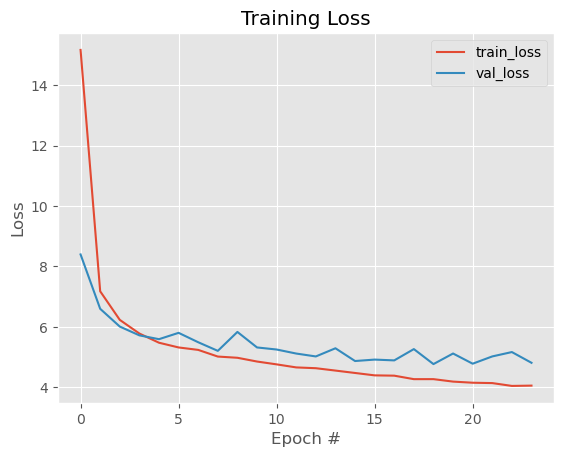

lr:  0.005  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 11s 22ms/step - loss: 14.5487 - val_loss: 7.9477
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: 7.2143 - val_loss: 6.2381
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 6.1400 - val_loss: 5.8162
Epoch 4/200
471/471 [==============================] - 10s 22ms/step - loss: 5.6973 - val_loss: 5.5796
Epoch 5/200
471/471 [==============================] - 11s 24ms/step - loss: 5.5026 - val_loss: 5.5291
Epoch 6/200
471/471 [==============================] - 9s 20ms/step - loss: 5.2644 - val_loss: 5.2846
Epoch 7/200
471/471 [==============================] - 10s 21ms/step - loss: 5.0905 - val_loss: 5.1846
Epoch 8/200
471/471 [==============================] - 11s 23ms/step - loss: 4.9622 - val_loss: 5.2558
Epoch 9/200
471/471 [==============================] - 10s 22ms/step - loss: 4.8739 - val_loss: 5.1786
Epoch 10/200
471/471 [=============

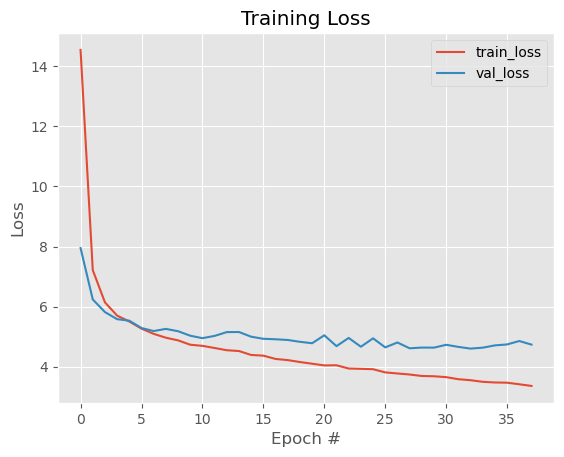

lr:  0.005  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 10s 21ms/step - loss: 13.0489 - val_loss: 8.0841
Epoch 2/200
471/471 [==============================] - 10s 20ms/step - loss: 6.8594 - val_loss: 6.1761
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 5.9858 - val_loss: 6.1229
Epoch 4/200
471/471 [==============================] - 11s 23ms/step - loss: 5.6579 - val_loss: 5.7701
Epoch 5/200
471/471 [==============================] - 11s 23ms/step - loss: 5.3574 - val_loss: 6.0869
Epoch 6/200
471/471 [==============================] - 11s 24ms/step - loss: 5.1634 - val_loss: 5.3547
Epoch 7/200
471/471 [==============================] - 10s 22ms/step - loss: 5.0905 - val_loss: 5.4185
Epoch 8/200
471/471 [==============================] - 11s 24ms/step - loss: 4.9944 - val_loss: 5.3223
Epoch 9/200
471/471 [==============================] - 11s 23ms/step - loss: 4.8439 - val_loss: 5.1590
Epoch 10/200
471/471 [============

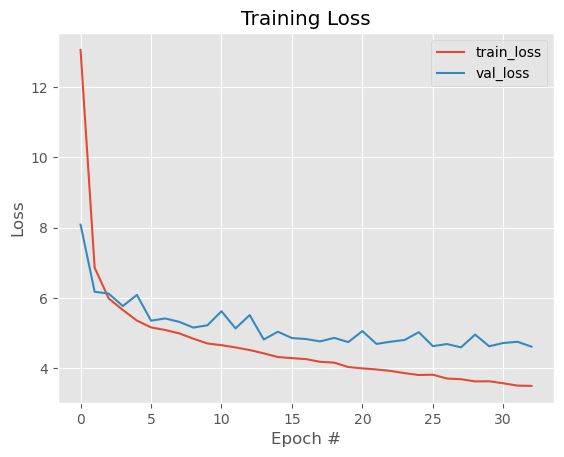

lr:  0.005  Hour_res:  1  Hex_res:  9
Epoch 1/200
471/471 [==============================] - 13s 26ms/step - loss: 14.0904 - val_loss: 7.5374
Epoch 2/200
471/471 [==============================] - 13s 27ms/step - loss: 6.8625 - val_loss: 6.1777
Epoch 3/200
471/471 [==============================] - 12s 25ms/step - loss: 6.0334 - val_loss: 5.7074
Epoch 4/200
471/471 [==============================] - 12s 26ms/step - loss: 5.6158 - val_loss: 5.7033
Epoch 5/200
471/471 [==============================] - 11s 24ms/step - loss: 5.4154 - val_loss: 5.3676
Epoch 6/200
471/471 [==============================] - 11s 24ms/step - loss: 5.1813 - val_loss: 5.2902
Epoch 7/200
471/471 [==============================] - 12s 26ms/step - loss: 5.0625 - val_loss: 5.2617
Epoch 8/200
471/471 [==============================] - 11s 24ms/step - loss: 4.9362 - val_loss: 5.4976
Epoch 9/200
471/471 [==============================] - 11s 23ms/step - loss: 4.8738 - val_loss: 5.2478
Epoch 10/200
471/471 [============

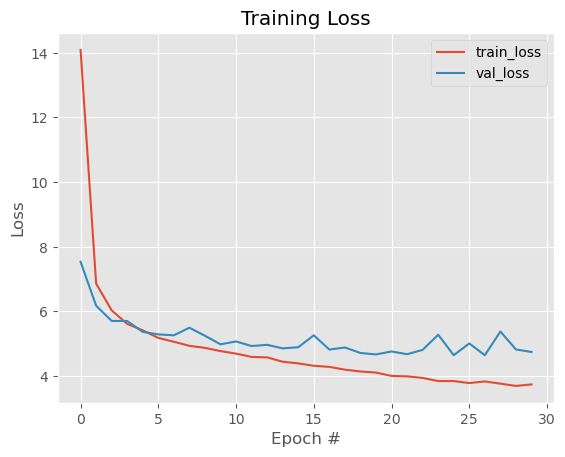

lr:  0.005  Hour_res:  2  Hex_res:  3
Epoch 1/200
429/429 [==============================] - 10s 22ms/step - loss: 46.4705 - val_loss: 48.0773
Epoch 2/200
429/429 [==============================] - 9s 22ms/step - loss: 46.2680 - val_loss: 48.5777
Epoch 3/200
429/429 [==============================] - 11s 26ms/step - loss: 46.5172 - val_loss: 47.9927
Epoch 4/200
429/429 [==============================] - 9s 21ms/step - loss: 46.3523 - val_loss: 45.4311
Epoch 5/200
429/429 [==============================] - 9s 20ms/step - loss: 46.5003 - val_loss: 47.9405
Epoch 6/200
429/429 [==============================] - 9s 20ms/step - loss: 35.5728 - val_loss: 18.1953
Epoch 7/200
429/429 [==============================] - 9s 20ms/step - loss: 15.1737 - val_loss: 13.8918
Epoch 8/200
429/429 [==============================] - 9s 20ms/step - loss: 11.9547 - val_loss: 11.0546
Epoch 9/200
429/429 [==============================] - 9s 20ms/step - loss: 10.5813 - val_loss: 10.0086
Epoch 10/200
429/429 [==

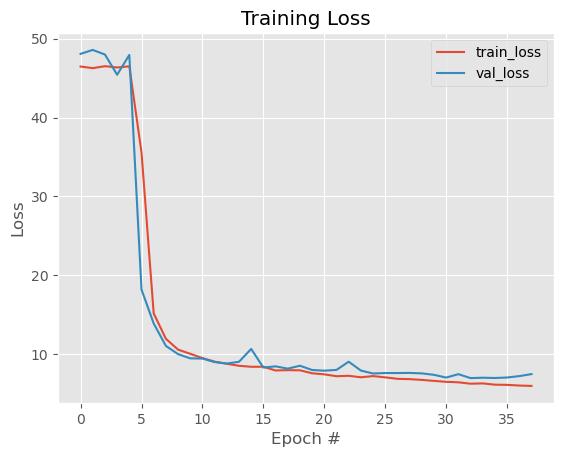

lr:  0.005  Hour_res:  2  Hex_res:  5
Epoch 1/200
429/429 [==============================] - 10s 22ms/step - loss: 45.4301 - val_loss: 33.1640
Epoch 2/200
429/429 [==============================] - 9s 21ms/step - loss: 20.0347 - val_loss: 13.6505
Epoch 3/200
429/429 [==============================] - 9s 22ms/step - loss: 13.5084 - val_loss: 11.4045
Epoch 4/200
429/429 [==============================] - 9s 21ms/step - loss: 11.4761 - val_loss: 11.3439
Epoch 5/200
429/429 [==============================] - 8s 20ms/step - loss: 10.3831 - val_loss: 10.9086
Epoch 6/200
429/429 [==============================] - 9s 21ms/step - loss: 9.6994 - val_loss: 9.7835
Epoch 7/200
429/429 [==============================] - 8s 20ms/step - loss: 9.3016 - val_loss: 10.7376
Epoch 8/200
429/429 [==============================] - 8s 20ms/step - loss: 8.8972 - val_loss: 8.8923
Epoch 9/200
429/429 [==============================] - 9s 21ms/step - loss: 8.6816 - val_loss: 8.7256
Epoch 10/200
429/429 [==========

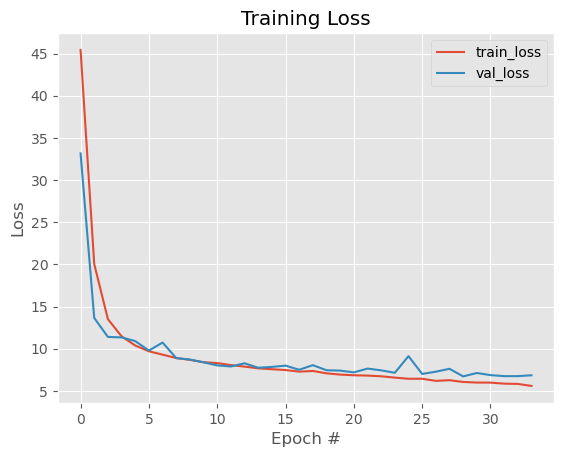

lr:  0.005  Hour_res:  2  Hex_res:  7
Epoch 1/200
429/429 [==============================] - 10s 22ms/step - loss: 23.0313 - val_loss: 13.2257
Epoch 2/200
429/429 [==============================] - 9s 21ms/step - loss: 11.5345 - val_loss: 10.4244
Epoch 3/200
429/429 [==============================] - 9s 21ms/step - loss: 10.1355 - val_loss: 9.8265
Epoch 4/200
429/429 [==============================] - 9s 21ms/step - loss: 9.6504 - val_loss: 8.6707
Epoch 5/200
429/429 [==============================] - 9s 21ms/step - loss: 8.8818 - val_loss: 8.5316
Epoch 6/200
429/429 [==============================] - 9s 21ms/step - loss: 8.7374 - val_loss: 8.3038
Epoch 7/200
429/429 [==============================] - 9s 21ms/step - loss: 8.2199 - val_loss: 8.7456
Epoch 8/200
429/429 [==============================] - 9s 21ms/step - loss: 7.9770 - val_loss: 7.8790
Epoch 9/200
429/429 [==============================] - 10s 23ms/step - loss: 7.7318 - val_loss: 8.2089
Epoch 10/200
429/429 [===============

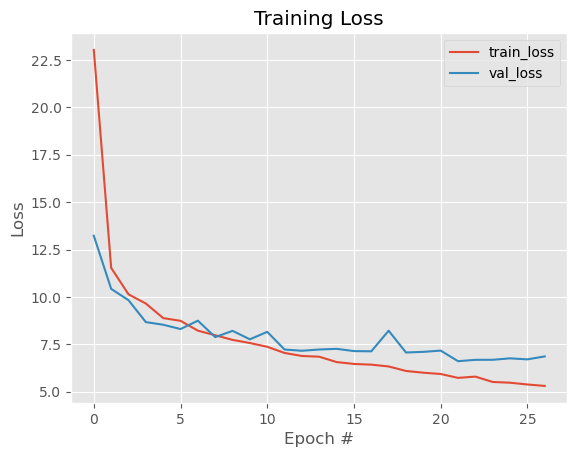

lr:  0.005  Hour_res:  2  Hex_res:  9
Epoch 1/200
429/429 [==============================] - 11s 25ms/step - loss: 23.9002 - val_loss: 11.8174
Epoch 2/200
429/429 [==============================] - 10s 23ms/step - loss: 11.4381 - val_loss: 11.3934
Epoch 3/200
429/429 [==============================] - 10s 23ms/step - loss: 10.0919 - val_loss: 9.9212
Epoch 4/200
429/429 [==============================] - 10s 23ms/step - loss: 9.5208 - val_loss: 9.2127
Epoch 5/200
429/429 [==============================] - 10s 23ms/step - loss: 8.7612 - val_loss: 8.4840
Epoch 6/200
429/429 [==============================] - 10s 23ms/step - loss: 8.5408 - val_loss: 8.3522
Epoch 7/200
429/429 [==============================] - 10s 23ms/step - loss: 8.2879 - val_loss: 8.4286
Epoch 8/200
429/429 [==============================] - 10s 23ms/step - loss: 8.0025 - val_loss: 7.8977
Epoch 9/200
429/429 [==============================] - 10s 23ms/step - loss: 7.6445 - val_loss: 8.8317
Epoch 10/200
429/429 [========

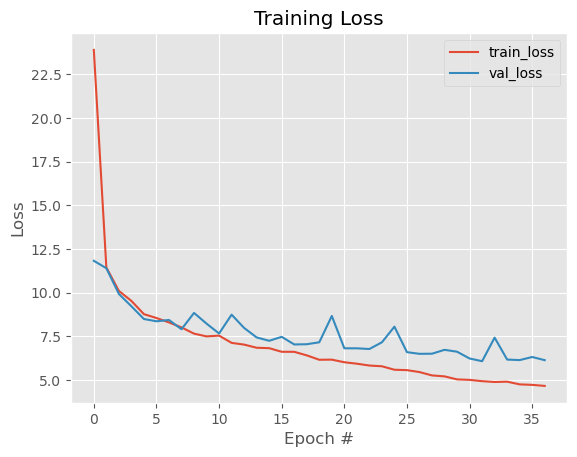

lr:  0.005  Hour_res:  6  Hex_res:  3
Epoch 1/200
378/378 [==============================] - 8s 20ms/step - loss: 134.0854 - val_loss: 139.3978
Epoch 2/200
378/378 [==============================] - 8s 21ms/step - loss: 130.6959 - val_loss: 139.1288
Epoch 3/200
378/378 [==============================] - 11s 29ms/step - loss: 128.7697 - val_loss: 131.7523
Epoch 4/200
378/378 [==============================] - 10s 27ms/step - loss: 83.2266 - val_loss: 41.9173
Epoch 5/200
378/378 [==============================] - 11s 29ms/step - loss: 34.2406 - val_loss: 26.5552
Epoch 6/200
378/378 [==============================] - 9s 24ms/step - loss: 29.2881 - val_loss: 24.0853
Epoch 7/200
378/378 [==============================] - 8s 21ms/step - loss: 24.6799 - val_loss: 25.7432
Epoch 8/200
378/378 [==============================] - 8s 22ms/step - loss: 24.0984 - val_loss: 29.6762
Epoch 9/200
378/378 [==============================] - 8s 21ms/step - loss: 22.4000 - val_loss: 22.7129
Epoch 10/200
378/

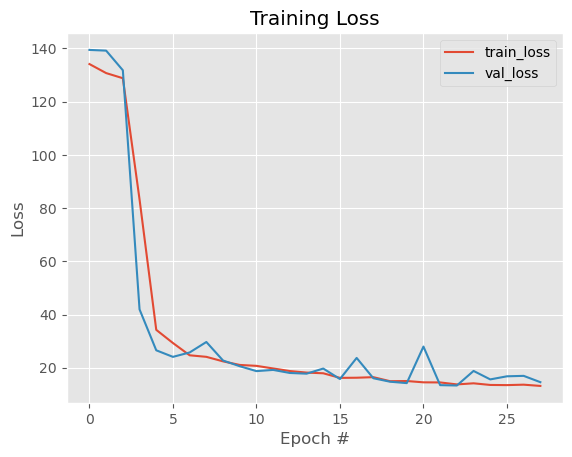

lr:  0.005  Hour_res:  6  Hex_res:  5
Epoch 1/200
378/378 [==============================] - 8s 20ms/step - loss: 134.9257 - val_loss: 129.7480
Epoch 2/200
378/378 [==============================] - 8s 22ms/step - loss: 135.9819 - val_loss: 137.1229
Epoch 3/200
378/378 [==============================] - 8s 22ms/step - loss: 133.9925 - val_loss: 139.4771
Epoch 4/200
378/378 [==============================] - 9s 25ms/step - loss: 129.9082 - val_loss: 133.4539
Epoch 5/200
378/378 [==============================] - 8s 21ms/step - loss: 79.6434 - val_loss: 39.1106
Epoch 6/200
378/378 [==============================] - 8s 22ms/step - loss: 35.2834 - val_loss: 48.2829
Epoch 7/200
378/378 [==============================] - 9s 23ms/step - loss: 31.6896 - val_loss: 26.7268
Epoch 8/200
378/378 [==============================] - 8s 22ms/step - loss: 28.1250 - val_loss: 27.5503
Epoch 9/200
378/378 [==============================] - 8s 21ms/step - loss: 25.2949 - val_loss: 21.5683
Epoch 10/200
378/3

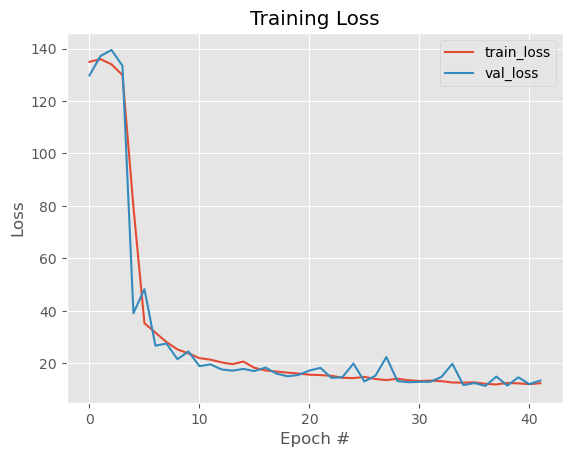

lr:  0.005  Hour_res:  6  Hex_res:  7
Epoch 1/200
378/378 [==============================] - 9s 23ms/step - loss: 63.3548 - val_loss: 28.3549
Epoch 2/200
378/378 [==============================] - 9s 23ms/step - loss: 28.0300 - val_loss: 23.6806
Epoch 3/200
378/378 [==============================] - 8s 21ms/step - loss: 25.7758 - val_loss: 25.7533
Epoch 4/200
378/378 [==============================] - 8s 22ms/step - loss: 24.2580 - val_loss: 26.7940
Epoch 5/200
378/378 [==============================] - 9s 23ms/step - loss: 20.4628 - val_loss: 21.6294
Epoch 6/200
378/378 [==============================] - 8s 21ms/step - loss: 19.8633 - val_loss: 27.8725
Epoch 7/200
378/378 [==============================] - 8s 21ms/step - loss: 18.6334 - val_loss: 16.4154
Epoch 8/200
378/378 [==============================] - 8s 21ms/step - loss: 17.2692 - val_loss: 20.3236
Epoch 9/200
378/378 [==============================] - 8s 21ms/step - loss: 17.2403 - val_loss: 17.8662
Epoch 10/200
378/378 [====

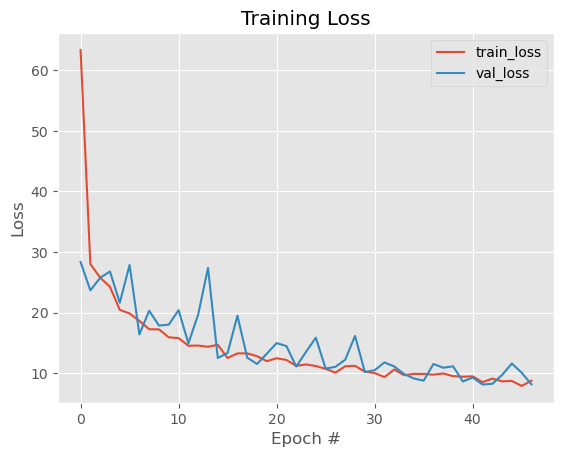

lr:  0.005  Hour_res:  6  Hex_res:  9
Epoch 1/200
378/378 [==============================] - 11s 27ms/step - loss: 60.6722 - val_loss: 27.3333
Epoch 2/200
378/378 [==============================] - 9s 23ms/step - loss: 28.3039 - val_loss: 27.5046
Epoch 3/200
378/378 [==============================] - 9s 23ms/step - loss: 25.0285 - val_loss: 23.3713
Epoch 4/200
378/378 [==============================] - 8s 22ms/step - loss: 21.5038 - val_loss: 20.1842
Epoch 5/200
378/378 [==============================] - 9s 23ms/step - loss: 20.5921 - val_loss: 24.4721
Epoch 6/200
378/378 [==============================] - 8s 22ms/step - loss: 19.7414 - val_loss: 24.2545
Epoch 7/200
378/378 [==============================] - 9s 24ms/step - loss: 18.4773 - val_loss: 22.7132
Epoch 8/200
378/378 [==============================] - 9s 24ms/step - loss: 17.0978 - val_loss: 16.3886
Epoch 9/200
378/378 [==============================] - 9s 23ms/step - loss: 17.1335 - val_loss: 15.9046
Epoch 10/200
378/378 [===

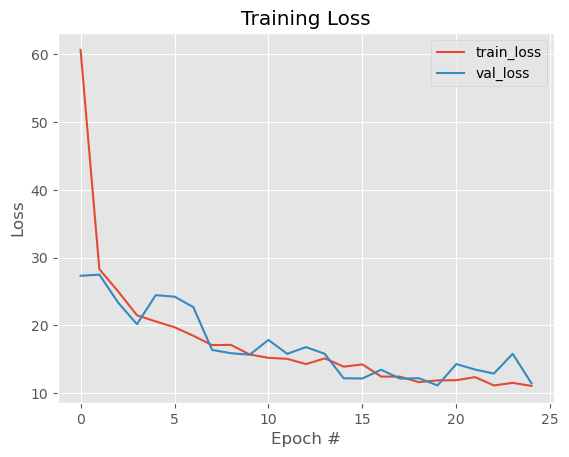

lr:  0.005  Hour_res:  24  Hex_res:  3
Epoch 1/200
323/323 [==============================] - 7s 21ms/step - loss: nan - val_loss: nan
Epoch 2/200
323/323 [==============================] - 7s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
323/323 [==============================] - 7s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
323/323 [==============================] - 7s 22ms/step - loss: nan - val_loss: nan
Epoch 5/200
323/323 [==============================] - 7s 20ms/step - loss: nan - val_loss: nan
Epoch 5: early stopping
Testset:

1614/1614 [==============================] - 4s 2ms/step - loss: nan
Test Loss:  nan


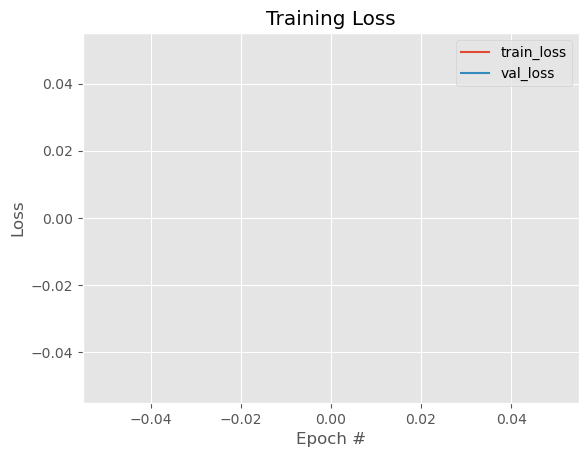

lr:  0.005  Hour_res:  24  Hex_res:  5
Epoch 1/200
323/323 [==============================] - 7s 21ms/step - loss: 480.7728 - val_loss: 465.0210
Epoch 2/200
323/323 [==============================] - 7s 23ms/step - loss: nan - val_loss: nan
Epoch 3/200
323/323 [==============================] - 7s 22ms/step - loss: nan - val_loss: nan
Epoch 4/200
323/323 [==============================] - 7s 22ms/step - loss: nan - val_loss: nan
Epoch 5/200
323/323 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
323/323 [==============================] - 7s 20ms/step - loss: nan - val_loss: nan
Epoch 6: early stopping
Testset:

1614/1614 [==============================] - 4s 2ms/step - loss: 469.1673
Test Loss:  469.16729736328125


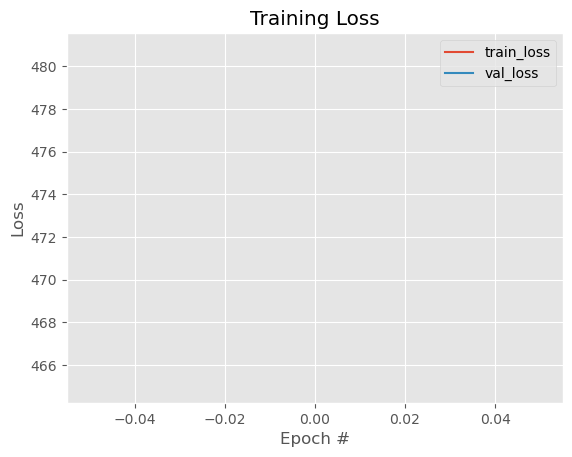

lr:  0.005  Hour_res:  24  Hex_res:  7
Epoch 1/200
323/323 [==============================] - 7s 21ms/step - loss: 495.4104 - val_loss: 485.8530
Epoch 2/200
323/323 [==============================] - 7s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
323/323 [==============================] - 7s 21ms/step - loss: nan - val_loss: nan
Epoch 4/200
323/323 [==============================] - 7s 21ms/step - loss: nan - val_loss: nan
Epoch 5/200
323/323 [==============================] - 7s 22ms/step - loss: nan - val_loss: nan
Epoch 6/200
323/323 [==============================] - 7s 22ms/step - loss: nan - val_loss: nan
Epoch 6: early stopping
Testset:

1614/1614 [==============================] - 4s 2ms/step - loss: 479.5721
Test Loss:  479.5720520019531


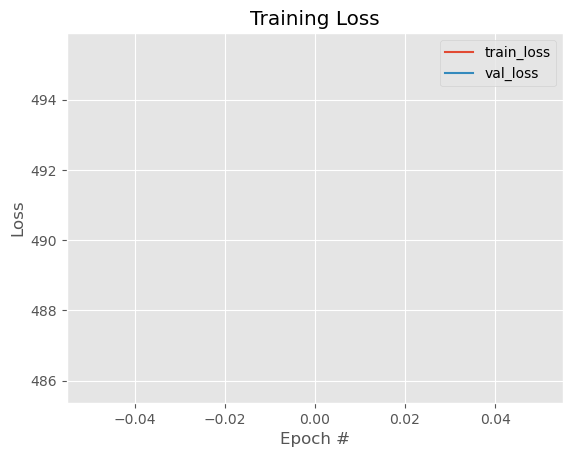

lr:  0.005  Hour_res:  24  Hex_res:  9
Epoch 1/200
323/323 [==============================] - 8s 25ms/step - loss: 470.3497 - val_loss: 470.8672
Epoch 2/200
323/323 [==============================] - 8s 24ms/step - loss: 480.7093 - val_loss: 519.5415
Epoch 3/200
323/323 [==============================] - 8s 23ms/step - loss: 470.3377 - val_loss: 469.9155
Epoch 4/200
323/323 [==============================] - 8s 24ms/step - loss: 466.9357 - val_loss: 469.9141
Epoch 5/200
323/323 [==============================] - 7s 23ms/step - loss: 466.9435 - val_loss: 469.9636
Epoch 6/200
323/323 [==============================] - 8s 24ms/step - loss: 466.9352 - val_loss: 469.9381
Epoch 7/200
323/323 [==============================] - 8s 24ms/step - loss: 466.9311 - val_loss: 469.9812
Epoch 8/200
323/323 [==============================] - 8s 24ms/step - loss: 466.9226 - val_loss: 469.9278
Epoch 9/200
323/323 [==============================] - 8s 23ms/step - loss: 466.9303 - val_loss: 469.9507
Epoch 9

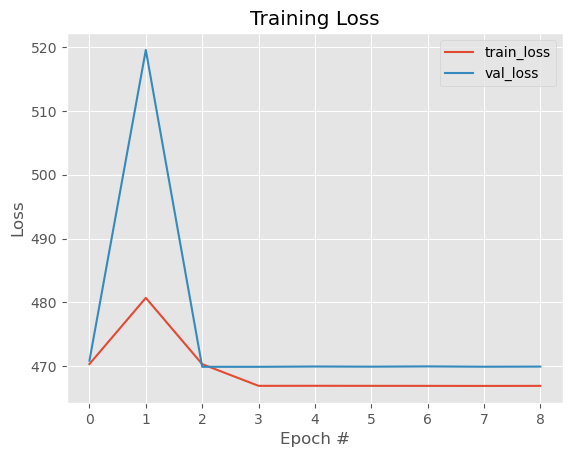

lr:  0.01  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7732 - val_loss: 23.7149
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7904 - val_loss: 23.6370
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8299 - val_loss: 23.5796
Epoch 4/200
471/471 [==============================] - 10s 22ms/step - loss: 23.8029 - val_loss: 23.5798
Epoch 5/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8029 - val_loss: 23.5795
Epoch 6/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8031 - val_loss: 23.5800
Epoch 7/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8032 - val_loss: 23.5799
Epoch 8/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8028 - val_loss: 23.5800
Epoch 8: early stopping
Testset:

2352/2352 [==============================] - 6s 2ms/step - loss: 23.8204
Test Loss:  23.8

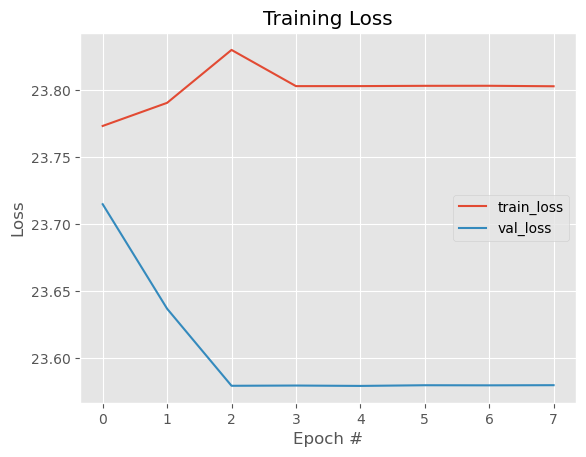

lr:  0.01  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 11s 22ms/step - loss: 23.5052 - val_loss: 23.7401
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: 23.6323 - val_loss: 21.9931
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 23.4776 - val_loss: 23.9533
Epoch 4/200
471/471 [==============================] - 10s 21ms/step - loss: 23.1776 - val_loss: 23.9971
Epoch 5/200
471/471 [==============================] - 10s 21ms/step - loss: 23.1766 - val_loss: 15.0040
Epoch 6/200
471/471 [==============================] - 10s 21ms/step - loss: 10.9745 - val_loss: 9.5510
Epoch 7/200
471/471 [==============================] - 10s 20ms/step - loss: 8.4689 - val_loss: 8.3255
Epoch 8/200
471/471 [==============================] - 10s 21ms/step - loss: 7.2982 - val_loss: 6.9896
Epoch 9/200
471/471 [==============================] - 10s 21ms/step - loss: 6.7495 - val_loss: 6.2232
Epoch 10/200
471/471 [===

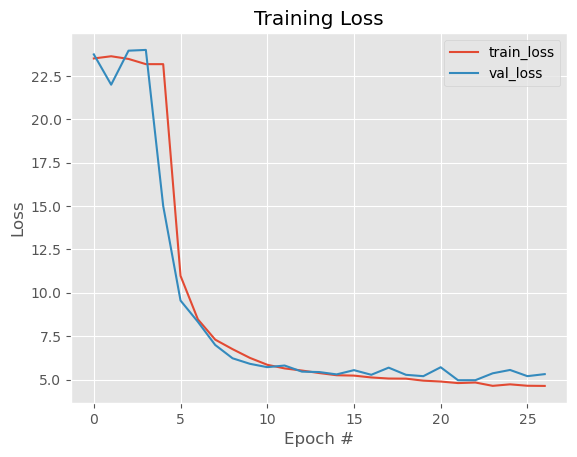

lr:  0.01  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 11s 23ms/step - loss: 11.3780 - val_loss: 7.7034
Epoch 2/200
471/471 [==============================] - 10s 22ms/step - loss: 6.5411 - val_loss: 6.7694
Epoch 3/200
471/471 [==============================] - 11s 23ms/step - loss: 6.0663 - val_loss: 5.5464
Epoch 4/200
471/471 [==============================] - 10s 22ms/step - loss: 5.6326 - val_loss: 5.5251
Epoch 5/200
471/471 [==============================] - 11s 22ms/step - loss: 5.5005 - val_loss: 5.2621
Epoch 6/200
471/471 [==============================] - 10s 22ms/step - loss: 5.1943 - val_loss: 5.3871
Epoch 7/200
471/471 [==============================] - 10s 22ms/step - loss: 5.1139 - val_loss: 5.1420
Epoch 8/200
471/471 [==============================] - 11s 23ms/step - loss: 4.9883 - val_loss: 4.9776
Epoch 9/200
471/471 [==============================] - 11s 23ms/step - loss: 4.8533 - val_loss: 5.0122
Epoch 10/200
471/471 [=============

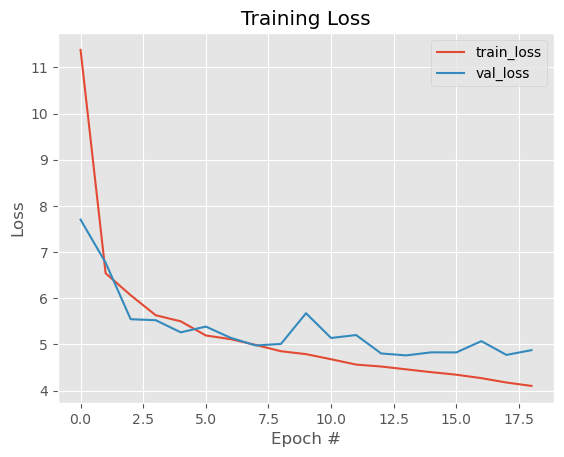

lr:  0.01  Hour_res:  1  Hex_res:  9
Epoch 1/200
471/471 [==============================] - 12s 24ms/step - loss: 12.1242 - val_loss: 6.9274
Epoch 2/200
471/471 [==============================] - 11s 23ms/step - loss: 6.6900 - val_loss: 6.8994
Epoch 3/200
471/471 [==============================] - 11s 23ms/step - loss: 6.0494 - val_loss: 5.7332
Epoch 4/200
471/471 [==============================] - 11s 24ms/step - loss: 5.6306 - val_loss: 5.4227
Epoch 5/200
471/471 [==============================] - 11s 23ms/step - loss: 5.4279 - val_loss: 5.4846
Epoch 6/200
471/471 [==============================] - 11s 24ms/step - loss: 5.2458 - val_loss: 5.2169
Epoch 7/200
471/471 [==============================] - 11s 23ms/step - loss: 5.1411 - val_loss: 5.2040
Epoch 8/200
471/471 [==============================] - 11s 23ms/step - loss: 5.0379 - val_loss: 5.9375
Epoch 9/200
471/471 [==============================] - 11s 24ms/step - loss: 4.8784 - val_loss: 5.1767
Epoch 10/200
471/471 [=============

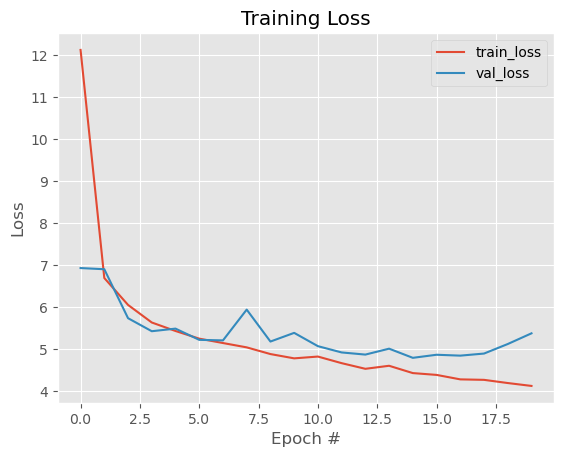

lr:  0.01  Hour_res:  2  Hex_res:  3
Epoch 1/200
429/429 [==============================] - 10s 22ms/step - loss: 46.6855 - val_loss: 47.4158
Epoch 2/200
429/429 [==============================] - 9s 20ms/step - loss: 46.9626 - val_loss: 47.1796
Epoch 3/200
429/429 [==============================] - 9s 21ms/step - loss: 40.7588 - val_loss: 21.4990
Epoch 4/200
429/429 [==============================] - 9s 21ms/step - loss: 19.0854 - val_loss: 16.4552
Epoch 5/200
429/429 [==============================] - 9s 20ms/step - loss: 14.5179 - val_loss: 12.9764
Epoch 6/200
429/429 [==============================] - 9s 21ms/step - loss: 12.7478 - val_loss: 10.8170
Epoch 7/200
429/429 [==============================] - 9s 20ms/step - loss: 11.4498 - val_loss: 10.6503
Epoch 8/200
429/429 [==============================] - 9s 21ms/step - loss: 10.2787 - val_loss: 10.1353
Epoch 9/200
429/429 [==============================] - 9s 20ms/step - loss: 9.6672 - val_loss: 9.0594
Epoch 10/200
429/429 [======

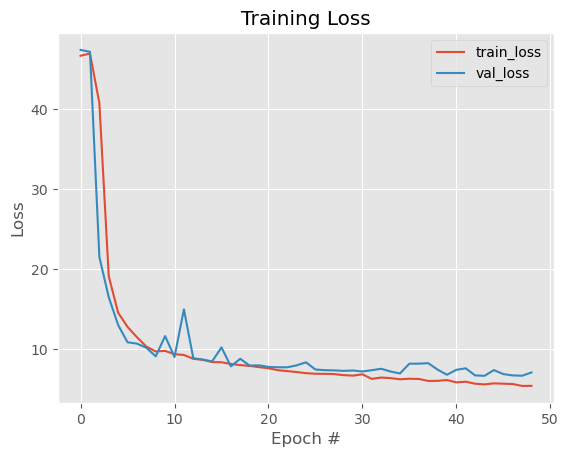

lr:  0.01  Hour_res:  2  Hex_res:  5
Epoch 1/200
429/429 [==============================] - 9s 21ms/step - loss: 46.3949 - val_loss: 45.1052
Epoch 2/200
429/429 [==============================] - 9s 20ms/step - loss: 46.5730 - val_loss: 46.8940
Epoch 3/200
429/429 [==============================] - 9s 20ms/step - loss: 38.7978 - val_loss: 20.5562
Epoch 4/200
429/429 [==============================] - 9s 20ms/step - loss: 17.3622 - val_loss: 13.5312
Epoch 5/200
429/429 [==============================] - 9s 21ms/step - loss: 13.1029 - val_loss: 13.9518
Epoch 6/200
429/429 [==============================] - 9s 21ms/step - loss: 11.5223 - val_loss: 10.4248
Epoch 7/200
429/429 [==============================] - 9s 20ms/step - loss: 10.8805 - val_loss: 10.2816
Epoch 8/200
429/429 [==============================] - 9s 20ms/step - loss: 10.0898 - val_loss: 10.0977
Epoch 9/200
429/429 [==============================] - 9s 20ms/step - loss: 9.9170 - val_loss: 9.9664
Epoch 10/200
429/429 [=======

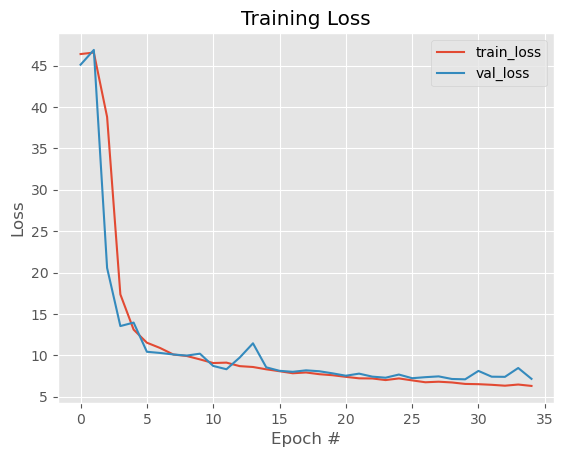

lr:  0.01  Hour_res:  2  Hex_res:  7
Epoch 1/200
429/429 [==============================] - 10s 22ms/step - loss: 21.5747 - val_loss: 12.7608
Epoch 2/200
429/429 [==============================] - 9s 21ms/step - loss: 12.0532 - val_loss: 14.4186
Epoch 3/200
429/429 [==============================] - 9s 21ms/step - loss: 10.6558 - val_loss: 11.4241
Epoch 4/200
429/429 [==============================] - 9s 22ms/step - loss: 9.8593 - val_loss: 9.3351
Epoch 5/200
429/429 [==============================] - 9s 22ms/step - loss: 9.4054 - val_loss: 11.0961
Epoch 6/200
429/429 [==============================] - 10s 23ms/step - loss: 9.1787 - val_loss: 8.3902
Epoch 7/200
429/429 [==============================] - 10s 24ms/step - loss: 8.5282 - val_loss: 8.2583
Epoch 8/200
429/429 [==============================] - 11s 25ms/step - loss: 8.1672 - val_loss: 8.3734
Epoch 9/200
429/429 [==============================] - 10s 23ms/step - loss: 8.0613 - val_loss: 8.9494
Epoch 10/200
429/429 [===========

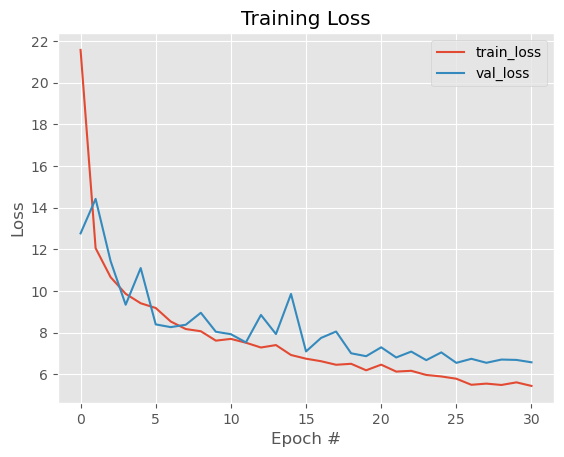

lr:  0.01  Hour_res:  2  Hex_res:  9
Epoch 1/200
429/429 [==============================] - 11s 24ms/step - loss: 21.2128 - val_loss: 11.6866
Epoch 2/200
429/429 [==============================] - 11s 25ms/step - loss: 11.8917 - val_loss: 10.5908
Epoch 3/200
429/429 [==============================] - 10s 23ms/step - loss: 10.4669 - val_loss: 9.1526
Epoch 4/200
429/429 [==============================] - 11s 25ms/step - loss: 9.9513 - val_loss: 9.8449
Epoch 5/200
429/429 [==============================] - 10s 23ms/step - loss: 9.6929 - val_loss: 8.4595
Epoch 6/200
429/429 [==============================] - 10s 23ms/step - loss: 8.7087 - val_loss: 9.9199
Epoch 7/200
429/429 [==============================] - 10s 23ms/step - loss: 8.5028 - val_loss: 8.5476
Epoch 8/200
429/429 [==============================] - 10s 22ms/step - loss: 8.2777 - val_loss: 8.8647
Epoch 9/200
429/429 [==============================] - 10s 23ms/step - loss: 8.0192 - val_loss: 8.1775
Epoch 10/200
429/429 [=========

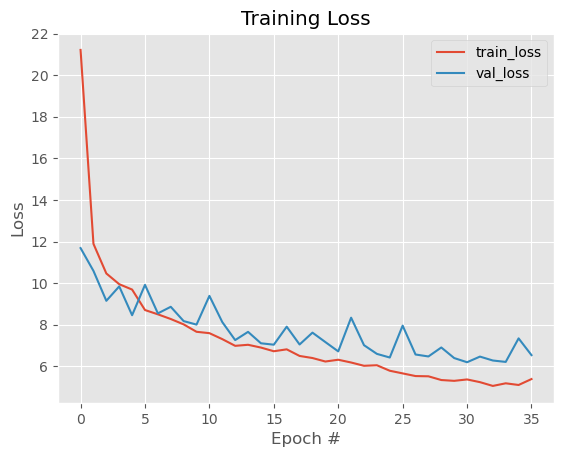

lr:  0.01  Hour_res:  6  Hex_res:  3
Epoch 1/200
378/378 [==============================] - 8s 21ms/step - loss: 136.4872 - val_loss: 136.7155
Epoch 2/200
378/378 [==============================] - 8s 21ms/step - loss: 136.7350 - val_loss: 133.4530
Epoch 3/200
378/378 [==============================] - 8s 21ms/step - loss: 134.7752 - val_loss: 129.3118
Epoch 4/200
378/378 [==============================] - 8s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
378/378 [==============================] - 8s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
378/378 [==============================] - 8s 21ms/step - loss: nan - val_loss: nan
Epoch 7/200
378/378 [==============================] - 8s 22ms/step - loss: nan - val_loss: nan
Epoch 8/200
378/378 [==============================] - 8s 22ms/step - loss: nan - val_loss: nan
Epoch 8: early stopping
Testset:

1888/1888 [==============================] - 5s 2ms/step - loss: 129.6909
Test Loss:  129.6908721923828


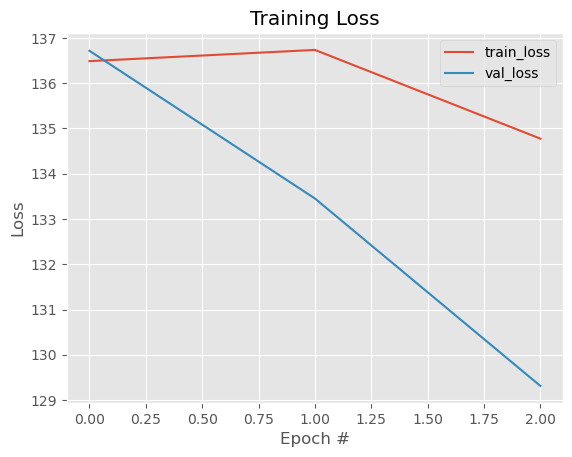

lr:  0.01  Hour_res:  6  Hex_res:  5
Epoch 1/200
378/378 [==============================] - 8s 21ms/step - loss: nan - val_loss: nan
Epoch 2/200
378/378 [==============================] - 8s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
378/378 [==============================] - 8s 21ms/step - loss: nan - val_loss: nan
Epoch 4/200
378/378 [==============================] - 8s 21ms/step - loss: nan - val_loss: nan
Epoch 5/200
378/378 [==============================] - 9s 23ms/step - loss: nan - val_loss: nan
Epoch 5: early stopping
Testset:

1888/1888 [==============================] - 4s 2ms/step - loss: nan
Test Loss:  nan


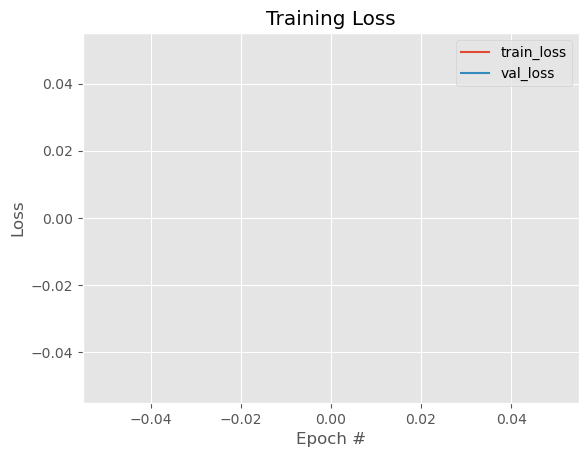

lr:  0.01  Hour_res:  6  Hex_res:  7
Epoch 1/200
378/378 [==============================] - 9s 22ms/step - loss: 91.3083 - val_loss: 60.2171
Epoch 2/200
378/378 [==============================] - 8s 21ms/step - loss: 35.3513 - val_loss: 31.1670
Epoch 3/200
378/378 [==============================] - 8s 22ms/step - loss: 30.2153 - val_loss: 26.0513
Epoch 4/200
378/378 [==============================] - 9s 23ms/step - loss: 25.9450 - val_loss: 23.3246
Epoch 5/200
378/378 [==============================] - 8s 22ms/step - loss: 23.0960 - val_loss: 21.1819
Epoch 6/200
378/378 [==============================] - 8s 21ms/step - loss: 21.7360 - val_loss: 21.5297
Epoch 7/200
378/378 [==============================] - 8s 22ms/step - loss: 21.4176 - val_loss: 18.5780
Epoch 8/200
378/378 [==============================] - 8s 22ms/step - loss: 20.1771 - val_loss: 20.2029
Epoch 9/200
378/378 [==============================] - 8s 21ms/step - loss: 20.4620 - val_loss: 22.9635
Epoch 10/200
378/378 [=====

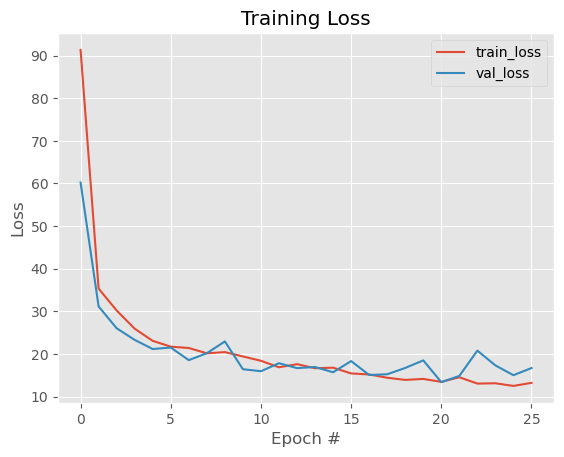

lr:  0.01  Hour_res:  6  Hex_res:  9
Epoch 1/200
378/378 [==============================] - 10s 24ms/step - loss: 136.0381 - val_loss: 133.7169
Epoch 2/200
378/378 [==============================] - 9s 23ms/step - loss: 102.6583 - val_loss: 39.0627
Epoch 3/200
378/378 [==============================] - 9s 23ms/step - loss: 41.7991 - val_loss: 29.0290
Epoch 4/200
378/378 [==============================] - 8s 22ms/step - loss: 30.8052 - val_loss: 24.8919
Epoch 5/200
378/378 [==============================] - 8s 22ms/step - loss: 26.4508 - val_loss: 22.7414
Epoch 6/200
378/378 [==============================] - 8s 22ms/step - loss: 23.9740 - val_loss: 26.0951
Epoch 7/200
378/378 [==============================] - 9s 23ms/step - loss: 23.3462 - val_loss: 20.2131
Epoch 8/200
378/378 [==============================] - 8s 22ms/step - loss: 22.5335 - val_loss: 20.8345
Epoch 9/200
378/378 [==============================] - 9s 23ms/step - loss: 21.0459 - val_loss: 21.2002
Epoch 10/200
378/378 [=

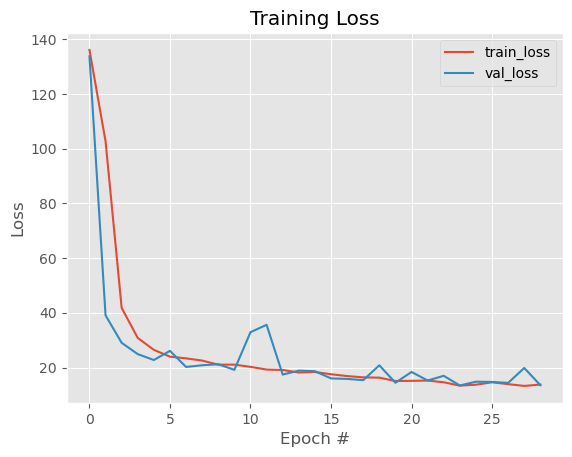

lr:  0.01  Hour_res:  24  Hex_res:  3
Epoch 1/200
323/323 [==============================] - 7s 21ms/step - loss: 481.4824 - val_loss: 462.7039
Epoch 2/200
323/323 [==============================] - 7s 20ms/step - loss: 469.8319 - val_loss: 462.7879
Epoch 3/200
323/323 [==============================] - 7s 21ms/step - loss: 469.7828 - val_loss: 462.6569
Epoch 4/200
323/323 [==============================] - 7s 21ms/step - loss: 469.7612 - val_loss: 462.6867
Epoch 5/200
323/323 [==============================] - 7s 21ms/step - loss: 469.7851 - val_loss: 462.7845
Epoch 6/200
323/323 [==============================] - 7s 20ms/step - loss: 469.7398 - val_loss: 462.7682
Epoch 7/200
323/323 [==============================] - 7s 21ms/step - loss: 469.7381 - val_loss: 462.7057
Epoch 8/200
323/323 [==============================] - 7s 20ms/step - loss: 469.7840 - val_loss: 462.6494
Epoch 9/200
323/323 [==============================] - 7s 20ms/step - loss: 469.7719 - val_loss: 462.6959
Epoch 10

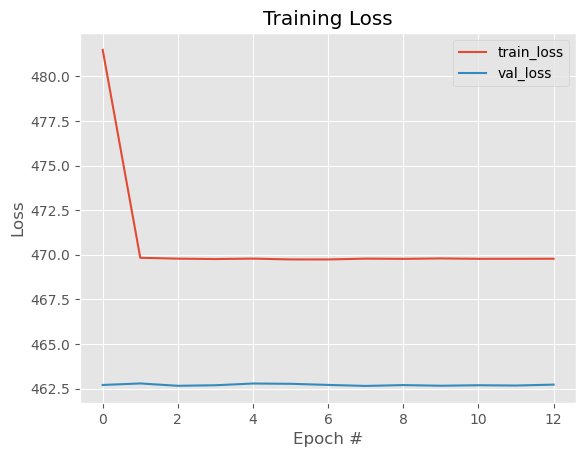

lr:  0.01  Hour_res:  24  Hex_res:  5
Epoch 1/200
323/323 [==============================] - 8s 25ms/step - loss: 480.9209 - val_loss: 471.1975
Epoch 2/200
323/323 [==============================] - 10s 30ms/step - loss: 469.5269 - val_loss: 470.8156
Epoch 3/200
323/323 [==============================] - 8s 26ms/step - loss: 469.4885 - val_loss: 471.3743
Epoch 4/200
323/323 [==============================] - 7s 22ms/step - loss: 469.4832 - val_loss: 470.8353
Epoch 5/200
323/323 [==============================] - 7s 23ms/step - loss: 469.4763 - val_loss: 470.8347
Epoch 6/200
323/323 [==============================] - 8s 24ms/step - loss: 469.4993 - val_loss: 471.1785
Epoch 7/200
323/323 [==============================] - 7s 22ms/step - loss: 469.5060 - val_loss: 471.0305
Epoch 7: early stopping
Testset:

1614/1614 [==============================] - 4s 2ms/step - loss: 464.0559
Test Loss:  464.055908203125


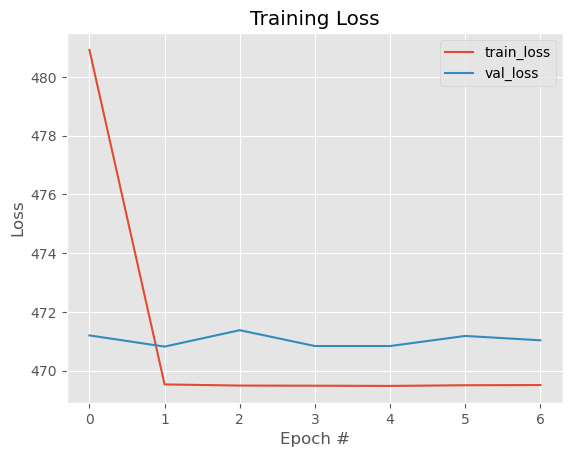

lr:  0.01  Hour_res:  24  Hex_res:  7
Epoch 1/200
323/323 [==============================] - 8s 23ms/step - loss: nan - val_loss: nan
Epoch 2/200
323/323 [==============================] - 8s 26ms/step - loss: nan - val_loss: nan
Epoch 3/200
323/323 [==============================] - 9s 28ms/step - loss: nan - val_loss: nan
Epoch 4/200
323/323 [==============================] - 9s 29ms/step - loss: nan - val_loss: nan
Epoch 5/200
323/323 [==============================] - 9s 29ms/step - loss: nan - val_loss: nan
Epoch 5: early stopping
Testset:

1614/1614 [==============================] - 5s 3ms/step - loss: nan
Test Loss:  nan


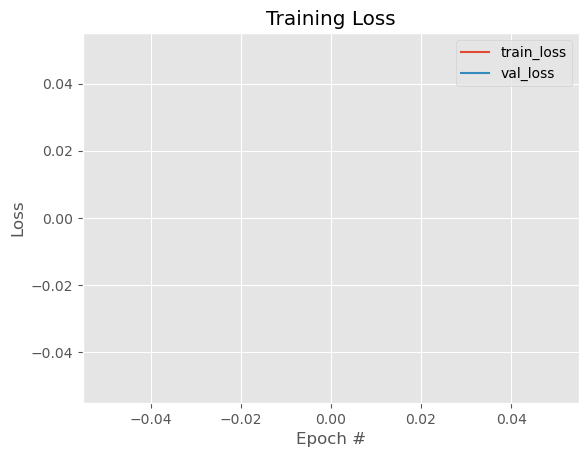

lr:  0.01  Hour_res:  24  Hex_res:  9
Epoch 1/200
323/323 [==============================] - 9s 26ms/step - loss: 483.1012 - val_loss: 564.1768
Epoch 2/200
323/323 [==============================] - 8s 24ms/step - loss: nan - val_loss: nan
Epoch 3/200
323/323 [==============================] - 9s 26ms/step - loss: nan - val_loss: nan
Epoch 4/200
323/323 [==============================] - 8s 25ms/step - loss: nan - val_loss: nan
Epoch 5/200
323/323 [==============================] - 8s 24ms/step - loss: nan - val_loss: nan
Epoch 6/200
323/323 [==============================] - 8s 24ms/step - loss: nan - val_loss: nan
Epoch 6: early stopping
Testset:

1614/1614 [==============================] - 4s 3ms/step - loss: 563.5060
Test Loss:  563.5060424804688


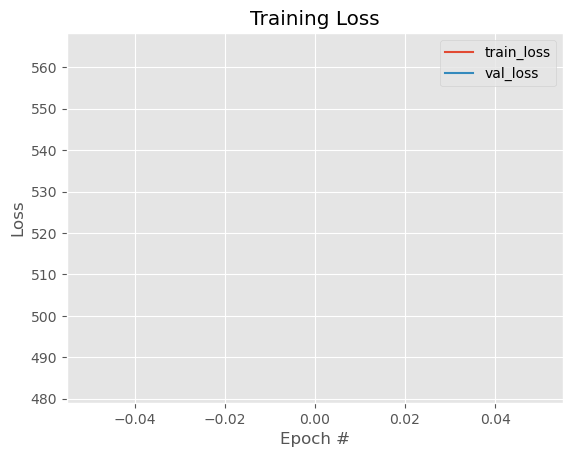

lr:  0.03  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 12s 24ms/step - loss: 21.1638 - val_loss: 12.3084
Epoch 2/200
471/471 [==============================] - 10s 22ms/step - loss: 8.8882 - val_loss: 7.5606
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 7.2033 - val_loss: 6.5180
Epoch 4/200
471/471 [==============================] - 11s 23ms/step - loss: 6.6629 - val_loss: 6.1039
Epoch 5/200
471/471 [==============================] - 10s 22ms/step - loss: 5.9972 - val_loss: 6.1565
Epoch 6/200
471/471 [==============================] - 11s 23ms/step - loss: 5.9327 - val_loss: 6.0474
Epoch 7/200
471/471 [==============================] - 11s 23ms/step - loss: 5.7843 - val_loss: 5.6596
Epoch 8/200
471/471 [==============================] - 11s 24ms/step - loss: 5.5757 - val_loss: 5.6065
Epoch 9/200
471/471 [==============================] - 11s 24ms/step - loss: 5.4756 - val_loss: 5.6413
Epoch 10/200
471/471 [============

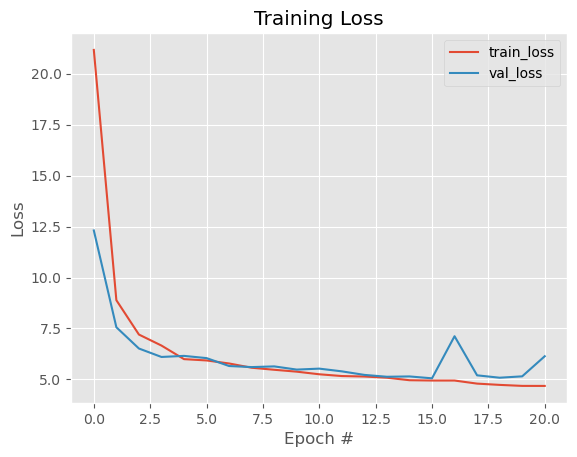

lr:  0.03  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 11s 23ms/step - loss: 23.6439 - val_loss: 24.5859
Epoch 2/200
471/471 [==============================] - 11s 23ms/step - loss: 16.0505 - val_loss: 9.0384
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 7.9282 - val_loss: 6.8159
Epoch 4/200
471/471 [==============================] - 11s 24ms/step - loss: 6.8607 - val_loss: 6.8866
Epoch 5/200
471/471 [==============================] - 12s 25ms/step - loss: 6.4638 - val_loss: 6.1988
Epoch 6/200
471/471 [==============================] - 14s 30ms/step - loss: 6.0172 - val_loss: 5.8882
Epoch 7/200
471/471 [==============================] - 11s 23ms/step - loss: 5.8534 - val_loss: 5.7323
Epoch 8/200
471/471 [==============================] - 10s 20ms/step - loss: 5.8049 - val_loss: 7.1562
Epoch 9/200
471/471 [==============================] - 10s 20ms/step - loss: 5.6328 - val_loss: 5.7693
Epoch 10/200
471/471 [===========

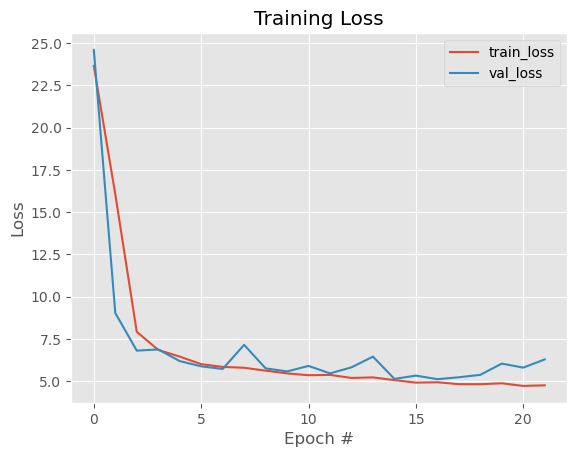

lr:  0.03  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 11s 22ms/step - loss: 23.4685 - val_loss: 23.4157
Epoch 2/200
414/471 [=========================>....] - ETA: 1s - loss: 15.6281

In [10]:
lr = [0.01, 0.03, 0.05]
resolution = [1, 2, 6, 24]
hex_res = [3, 5, 7]
result_list = []
data_sample = work_data.sample(10000000)
for i in lr:
    for j in resolution:
        for k in hex_res:
            data1 = create_dataset_more_data(data_sample,resolution=j,h3_res = k)
            network1 = models.Sequential()
            print(data1.shape)


            network1.add(layers.Dense(512, activation='relu', input_shape=(data1.shape[1]-1,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(1, activation='linear'))
          
            print("lr: ", i, " Hour_res: ", j, " Hex_res: ", k)
            TN1 = Train_Net(data1, network1, batch_size = 512, epochs = 200, learning_rate=i)
            loss, H, epochs_plot = TN1.train_net()
            result_list.append("lr: "+ str(i)+ " Hour_res: "+ str(j)+ " Hex_res: "+str(k)+ " Epochs before stopping:"+ str(epochs_plot) + " Test_loss: "+ str(loss) +" Demand mean value: " +str(data1[:,-1:].mean()))
result_list

In [ ]:
lr:  0.03  Hour_res:  1  Hex_res:  7

In [12]:
result_list

In [26]:
data_sample = work_data.sample(10000000)
data1 = create_dataset_more_data(work_data,resolution=24,h3_res = 5)
network1 = models.Sequential()
print(data1.shape)


network1.add(layers.Dense(512-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(1, activation='linear'))

TN1 = Train_Net(data1, network1, batch_size = 128, epochs = 100, learning_rate=0.01)
loss, H = TN1.train_net()

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
           ... 
16500977    0.0
16500978    0.0
16500979    0.0
16500980    0.0
16500981    0.0
Name: new_hour, Length: 16500982, dtype: float64
(274165, 615)
Epoch 1/100
1371/1371 [==============================] - 25s 18ms/step - loss: 763.6591 - val_loss: 758.5094
Epoch 2/100
1371/1371 [==============================] - 25s 18ms/step - loss: 748.6364 - val_loss: 752.0361
Epoch 3/100
1371/1371 [==============================] - 25s 18ms/step - loss: 744.4966 - val_loss: 749.3785
Epoch 4/100
1371/1371 [==============================] - 24s 18ms/step - loss: 742.6226 - val_loss: 748.0114
Epoch 5/100
1371/1371 [==============================] - 25s 18ms/step - loss: 741.6284 - val_loss: 747.2383
Epoch 6/100
1371/1371 [==============================] - 25s 18ms/step - loss: 741.0651 - val_loss: 746.7830
Epoch 7/100
1371/1371 [==============================] - 25s 18ms/step - loss: 740.7338 - val_loss: 746.513

KeyboardInterrupt: 

In [22]:
data1 = create_dataset_more_data(work_data,resolution=4,h3_res = 7)
network1 = models.Sequential()
#print(data1, data1.shape)


network1.add(layers.Dense(512-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(1, activation='linear'))

TN1 = Train_Net(data1, network1, batch_size = 128, epochs = 100, learning_rate=0.01)
loss, H = TN1.train_net()

KeyboardInterrupt: 

In [8]:
def create_dataset_more_data2(data, resolution=4):
    df = data.loc[:, ("start_census","weekday","hour","day","month","avg_temp")].copy()
    df = df.dropna()
    

    df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
    df = df.drop('hour', axis=1)
    df['new_hour'] = df['new_hour'].astype(int)
    
    
    df2 = df.loc[:, ("start_census","weekday","new_hour","day","month","avg_temp")]
    df2['occurrences'] = df2.groupby(["start_census","weekday","new_hour","day","month"]).transform('count')
    
    df2.drop_duplicates(inplace=True)
    column = 'avg_temp'
    df2[column] = (df2[column] - df2[column].min()) / (df2[column].max() - df2[column].min())    
    
    one_hot_data = df2.loc[:, ("start_census","weekday","new_hour","day","month")]
    OHEt = OHE().fit(one_hot_data.to_numpy())
    encoded_data = OHEt.transform(df2.loc[:, ("start_census","weekday","new_hour","day","month")].to_numpy())
    encoded_data = sparse.hstack((encoded_data,df2['avg_temp'].to_numpy().reshape(-1, 1)))
    encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
    encoded_data = sparse.csr_matrix(encoded_data)
    encoded_data = encoded_data.todense()
    
    return encoded_data

In [9]:
def create_dataset(data, resolution=4, use_h3=True, h3_res = 3):
    df = data.copy()
    if use_h3:
        df = df.h3.geo_to_h3(h3_res)
        df["h3"] = df.index
        df = df.loc[:, ("start_census","hour","h3")].copy()
        df.reset_index(inplace=True, drop=True)
        df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
        df = df.drop('hour', axis=1)
        df['new_hour'] = df['new_hour'].astype(int)


        df2 = df.loc[:, ("start_census","new_hour","h3")]
        df2["temp"] = np.ones(df2.shape[0])
        df2['occurrences'] = df2.groupby(["start_census","new_hour","h3"]).transform('count')
        df2.drop_duplicates(inplace=True)
        one_hot_data = df2.loc[:, ("start_census","new_hour","h3")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","new_hour","h3")].to_numpy())
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()
    else:
        df = df.loc[:, ("start_census","hour")]
        
        df = df.dropna()

        df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
        df = df.drop('hour', axis=1)
        df['new_hour'] = df['new_hour'].astype(int)


        df2 = df.loc[:, ("start_census","new_hour")]
        df2["temp"] = np.ones(df2.shape[0])
        df2['occurrences'] = df2.groupby(["start_census","new_hour"]).transform('count')
        df2.drop_duplicates(inplace=True)
        one_hot_data = df2.loc[:, ("start_census","new_hour")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","new_hour")].to_numpy())
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()

    return encoded_data

          start_census  hour               h3
0         1.703108e+10     0  832664fffffffff
1         1.703184e+10     0  832664fffffffff
2         1.703128e+10     0  832664fffffffff
3         1.703108e+10     0  832664fffffffff
4         1.703184e+10     0  832664fffffffff
...                ...   ...              ...
16500977  1.703108e+10    23  832664fffffffff
16500978  1.703108e+10    23  832664fffffffff
16500979  1.703108e+10    23  832664fffffffff
16500980  1.703124e+10    23  832664fffffffff
16500981  1.703108e+10    23  832664fffffffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  832664fffffffff   1.0        17604
1         1.703184e+10         0  832664fffffffff   1.0        27827
2         1.703128e+10         0  832664fffffffff   1.0         5873
3         1.703108e+10         0  832664fffffffff   1.0         9714
7         1.703108e+10         0  832664fffffffff   1.0         5107
...  

61/61 [==============================] - 0s 2ms/step - loss: 976.5222 - val_loss: 1281.9822
Epoch 138/300
61/61 [==============================] - 0s 2ms/step - loss: 968.7908 - val_loss: 1282.5472
Epoch 139/300
61/61 [==============================] - 0s 2ms/step - loss: 965.5174 - val_loss: 1277.5321
Epoch 140/300
61/61 [==============================] - 0s 2ms/step - loss: 968.9105 - val_loss: 1298.5166
Epoch 141/300
61/61 [==============================] - 0s 3ms/step - loss: 967.6710 - val_loss: 1274.8241
Epoch 142/300
61/61 [==============================] - 0s 2ms/step - loss: 979.2908 - val_loss: 1299.2649
Epoch 143/300
61/61 [==============================] - 0s 2ms/step - loss: 1014.3528 - val_loss: 1258.5317
Epoch 144/300
61/61 [==============================] - 0s 2ms/step - loss: 975.4929 - val_loss: 1360.8134
Epoch 145/300
61/61 [==============================] - 0s 2ms/step - loss: 1008.5815 - val_loss: 1282.4407
Epoch 146/300
61/61 [==============================] - 0s 

61/61 [==============================] - 0s 2ms/step - loss: 938.8735 - val_loss: 1291.1301
Epoch 292/300
61/61 [==============================] - 0s 2ms/step - loss: 927.6002 - val_loss: 1303.1075
Epoch 293/300
61/61 [==============================] - 0s 2ms/step - loss: 957.5743 - val_loss: 1276.8500
Epoch 294/300
61/61 [==============================] - 0s 2ms/step - loss: 951.0363 - val_loss: 1327.3793
Epoch 295/300
61/61 [==============================] - 0s 2ms/step - loss: 940.7032 - val_loss: 1309.8776
Epoch 296/300
61/61 [==============================] - 0s 2ms/step - loss: 921.1609 - val_loss: 1293.4996
Epoch 297/300
61/61 [==============================] - 0s 2ms/step - loss: 924.0967 - val_loss: 1290.8177
Epoch 298/300
61/61 [==============================] - 0s 2ms/step - loss: 1011.7360 - val_loss: 1282.7903
Epoch 299/300
61/61 [==============================] - 0s 2ms/step - loss: 924.0652 - val_loss: 1311.7185
Epoch 300/300
61/61 [==============================] - 0s 2

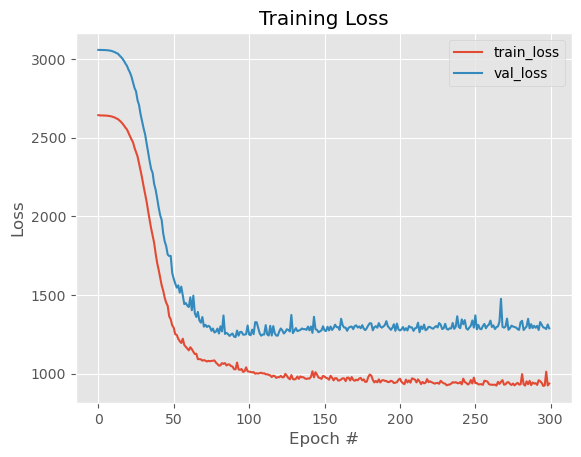

          start_census  hour               h3
0         1.703108e+10     0  852664c3fffffff
1         1.703184e+10     0  852664c3fffffff
2         1.703128e+10     0  852664c3fffffff
3         1.703108e+10     0  852664c3fffffff
4         1.703184e+10     0  852664c3fffffff
...                ...   ...              ...
16500977  1.703108e+10    23  852664c3fffffff
16500978  1.703108e+10    23  852664c3fffffff
16500979  1.703108e+10    23  852664c3fffffff
16500980  1.703124e+10    23  852664cbfffffff
16500981  1.703108e+10    23  852664c3fffffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  852664c3fffffff   1.0        17604
1         1.703184e+10         0  852664c3fffffff   1.0        27827
2         1.703128e+10         0  852664c3fffffff   1.0         5873
3         1.703108e+10         0  852664c3fffffff   1.0         9714
7         1.703108e+10         0  852664c3fffffff   1.0         5107
...  

61/61 [==============================] - 0s 2ms/step - loss: 2633.8342 - val_loss: 2950.4146
Epoch 138/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8347 - val_loss: 2950.4136
Epoch 139/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8342 - val_loss: 2950.4141
Epoch 140/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8342 - val_loss: 2950.4119
Epoch 141/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8337 - val_loss: 2950.4121
Epoch 142/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8335 - val_loss: 2950.4126
Epoch 143/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8342 - val_loss: 2950.4141
Epoch 144/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8342 - val_loss: 2950.4141
Epoch 145/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8342 - val_loss: 2950.4141
Epoch 146/300
61/61 [==============================

61/61 [==============================] - 0s 2ms/step - loss: 2633.8337 - val_loss: 2950.4121
Epoch 290/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8342 - val_loss: 2950.4119
Epoch 291/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8347 - val_loss: 2950.4119
Epoch 292/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8335 - val_loss: 2950.4133
Epoch 293/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8342 - val_loss: 2950.4146
Epoch 294/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8345 - val_loss: 2950.4124
Epoch 295/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8342 - val_loss: 2950.4126
Epoch 296/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8340 - val_loss: 2950.4124
Epoch 297/300
61/61 [==============================] - 0s 2ms/step - loss: 2633.8350 - val_loss: 2950.4116
Epoch 298/300
61/61 [==============================

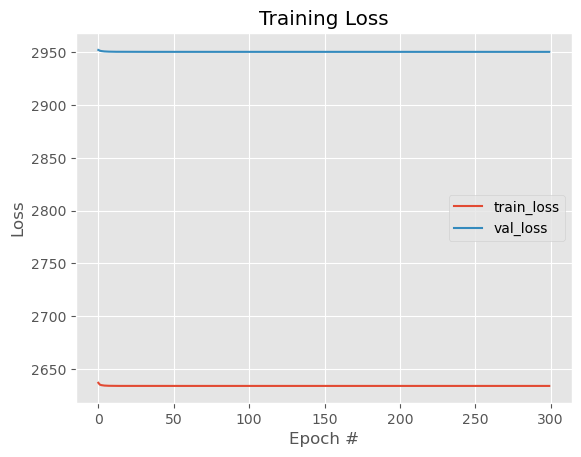

          start_census  hour               h3
0         1.703108e+10     0  872664c1effffff
1         1.703184e+10     0  872664c1affffff
2         1.703128e+10     0  872664c1affffff
3         1.703108e+10     0  872664c1effffff
4         1.703184e+10     0  872664c1affffff
...                ...   ...              ...
16500977  1.703108e+10    23  872664c1effffff
16500978  1.703108e+10    23  872664c1effffff
16500979  1.703108e+10    23  872664c1effffff
16500980  1.703124e+10    23  872664cacffffff
16500981  1.703108e+10    23  872664c1effffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  872664c1effffff   1.0        17604
1         1.703184e+10         0  872664c1affffff   1.0        27827
2         1.703128e+10         0  872664c1affffff   1.0         5873
3         1.703108e+10         0  872664c1effffff   1.0         9714
7         1.703108e+10         0  872664c1effffff   1.0         5107
...  

Epoch 138/300
61/61 [==============================] - 0s 2ms/step - loss: 906.7200 - val_loss: 1232.6024
Epoch 139/300
61/61 [==============================] - 0s 2ms/step - loss: 896.2485 - val_loss: 1221.1628
Epoch 140/300
61/61 [==============================] - 0s 2ms/step - loss: 906.5308 - val_loss: 1296.7374
Epoch 141/300
61/61 [==============================] - 0s 2ms/step - loss: 916.9962 - val_loss: 1242.1190
Epoch 142/300
61/61 [==============================] - 0s 2ms/step - loss: 903.9308 - val_loss: 1231.7578
Epoch 143/300
61/61 [==============================] - 0s 2ms/step - loss: 915.6635 - val_loss: 1264.5930
Epoch 144/300
61/61 [==============================] - 0s 2ms/step - loss: 901.8051 - val_loss: 1261.7859
Epoch 145/300
61/61 [==============================] - 0s 2ms/step - loss: 903.9225 - val_loss: 1238.6165
Epoch 146/300
61/61 [==============================] - 0s 2ms/step - loss: 905.4059 - val_loss: 1255.0118
Epoch 147/300
61/61 [=========================

61/61 [==============================] - 0s 2ms/step - loss: 910.5408 - val_loss: 1228.6018
Epoch 293/300
61/61 [==============================] - 0s 2ms/step - loss: 897.5413 - val_loss: 1228.1844
Epoch 294/300
61/61 [==============================] - 0s 2ms/step - loss: 896.4782 - val_loss: 1258.6741
Epoch 295/300
61/61 [==============================] - 0s 2ms/step - loss: 903.4161 - val_loss: 1266.7416
Epoch 296/300
61/61 [==============================] - 0s 2ms/step - loss: 894.8831 - val_loss: 1224.0935
Epoch 297/300
61/61 [==============================] - 0s 2ms/step - loss: 895.6254 - val_loss: 1260.8391
Epoch 298/300
61/61 [==============================] - 0s 2ms/step - loss: 881.6301 - val_loss: 1273.1465
Epoch 299/300
61/61 [==============================] - 0s 2ms/step - loss: 895.4169 - val_loss: 1285.3411
Epoch 300/300
61/61 [==============================] - 0s 2ms/step - loss: 891.4096 - val_loss: 1230.4950
Testset:

38/38 [==============================] - 0s 1ms/st

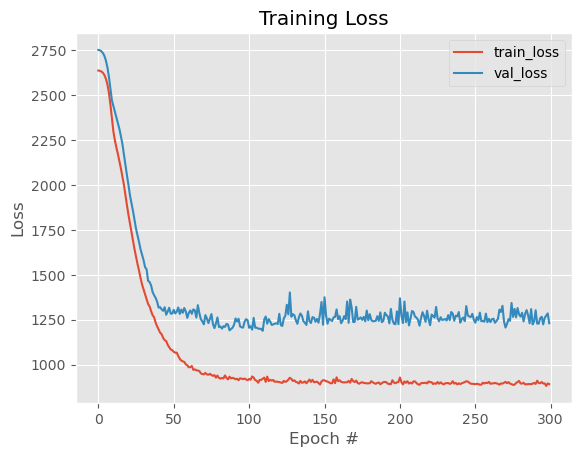

          start_census  hour               h3
0         1.703108e+10     0  892664c1e4fffff
1         1.703184e+10     0  892664c1a8bffff
2         1.703128e+10     0  892664c1acfffff
3         1.703108e+10     0  892664c1ec7ffff
4         1.703184e+10     0  892664c1a8bffff
...                ...   ...              ...
16500977  1.703108e+10    23  892664c1e73ffff
16500978  1.703108e+10    23  892664c1e0fffff
16500979  1.703108e+10    23  892664c1ea7ffff
16500980  1.703124e+10    23  892664cac03ffff
16500981  1.703108e+10    23  892664c1e0fffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  892664c1e4fffff   1.0        17604
1         1.703184e+10         0  892664c1a8bffff   1.0        27827
2         1.703128e+10         0  892664c1acfffff   1.0         5873
3         1.703108e+10         0  892664c1ec7ffff   1.0         9714
7         1.703108e+10         0  892664c1ed7ffff   1.0         5107
...  

61/61 [==============================] - 0s 2ms/step - loss: 953.7798 - val_loss: 939.5465
Epoch 139/300
61/61 [==============================] - 0s 2ms/step - loss: 956.8724 - val_loss: 944.2507
Epoch 140/300
61/61 [==============================] - 0s 2ms/step - loss: 960.4630 - val_loss: 945.4198
Epoch 141/300
61/61 [==============================] - 0s 2ms/step - loss: 963.4409 - val_loss: 920.8818
Epoch 142/300
61/61 [==============================] - 0s 2ms/step - loss: 954.1543 - val_loss: 935.3861
Epoch 143/300
61/61 [==============================] - 0s 2ms/step - loss: 949.6519 - val_loss: 938.2701
Epoch 144/300
61/61 [==============================] - 0s 2ms/step - loss: 948.9926 - val_loss: 945.1924
Epoch 145/300
61/61 [==============================] - 0s 2ms/step - loss: 947.2966 - val_loss: 946.1069
Epoch 146/300
61/61 [==============================] - 0s 2ms/step - loss: 959.2715 - val_loss: 925.1971
Epoch 147/300
61/61 [==============================] - 0s 2ms/step - 

61/61 [==============================] - 0s 2ms/step - loss: 916.9233 - val_loss: 943.7559
Epoch 295/300
61/61 [==============================] - 0s 2ms/step - loss: 915.4150 - val_loss: 931.7953
Epoch 296/300
61/61 [==============================] - 0s 2ms/step - loss: 903.5983 - val_loss: 902.5603
Epoch 297/300
61/61 [==============================] - 0s 2ms/step - loss: 920.4941 - val_loss: 906.2581
Epoch 298/300
61/61 [==============================] - 0s 2ms/step - loss: 913.4125 - val_loss: 905.7791
Epoch 299/300
61/61 [==============================] - 0s 2ms/step - loss: 918.7053 - val_loss: 903.0269
Epoch 300/300
61/61 [==============================] - 0s 2ms/step - loss: 916.0408 - val_loss: 925.6769
Testset:

38/38 [==============================] - 0s 1ms/step - loss: 1228.3486
Test Loss:  1228.3486328125


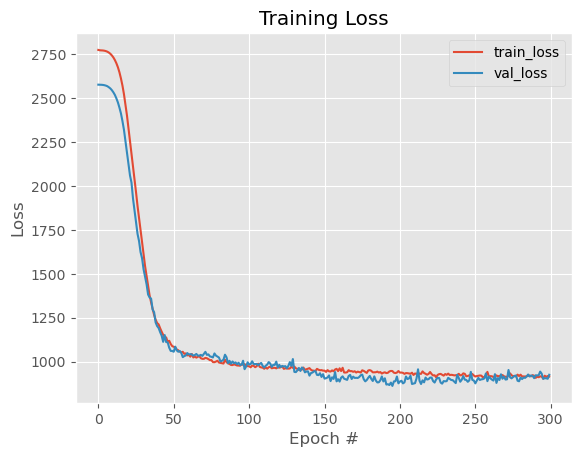

          start_census  hour               h3
0         1.703108e+10     0  832664fffffffff
1         1.703184e+10     0  832664fffffffff
2         1.703128e+10     0  832664fffffffff
3         1.703108e+10     0  832664fffffffff
4         1.703184e+10     0  832664fffffffff
...                ...   ...              ...
16500977  1.703108e+10    23  832664fffffffff
16500978  1.703108e+10    23  832664fffffffff
16500979  1.703108e+10    23  832664fffffffff
16500980  1.703124e+10    23  832664fffffffff
16500981  1.703108e+10    23  832664fffffffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  832664fffffffff   1.0        37757
1         1.703184e+10         0  832664fffffffff   1.0        40769
2         1.703128e+10         0  832664fffffffff   1.0         7456
3         1.703108e+10         0  832664fffffffff   1.0        20129
7         1.703108e+10         0  832664fffffffff   1.0         8747
...  

36/36 [==============================] - 0s 2ms/step - loss: 4820.5767 - val_loss: 5301.9800
Epoch 138/300
36/36 [==============================] - 0s 3ms/step - loss: 4820.5762 - val_loss: 5301.9800
Epoch 139/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5762 - val_loss: 5301.9800
Epoch 140/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5767 - val_loss: 5301.9800
Epoch 141/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5762 - val_loss: 5301.9800
Epoch 142/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5762 - val_loss: 5301.9800
Epoch 143/300
36/36 [==============================] - 0s 3ms/step - loss: 4820.5762 - val_loss: 5301.9795
Epoch 144/300
36/36 [==============================] - 0s 3ms/step - loss: 4820.5762 - val_loss: 5301.9800
Epoch 145/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5762 - val_loss: 5301.9790
Epoch 146/300
36/36 [==============================

36/36 [==============================] - 0s 2ms/step - loss: 4820.5767 - val_loss: 5301.9790
Epoch 290/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5762 - val_loss: 5301.9800
Epoch 291/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5762 - val_loss: 5301.9800
Epoch 292/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5762 - val_loss: 5301.9800
Epoch 293/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5762 - val_loss: 5301.9805
Epoch 294/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5767 - val_loss: 5301.9805
Epoch 295/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5762 - val_loss: 5301.9795
Epoch 296/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5762 - val_loss: 5301.9790
Epoch 297/300
36/36 [==============================] - 0s 2ms/step - loss: 4820.5767 - val_loss: 5301.9800
Epoch 298/300
36/36 [==============================

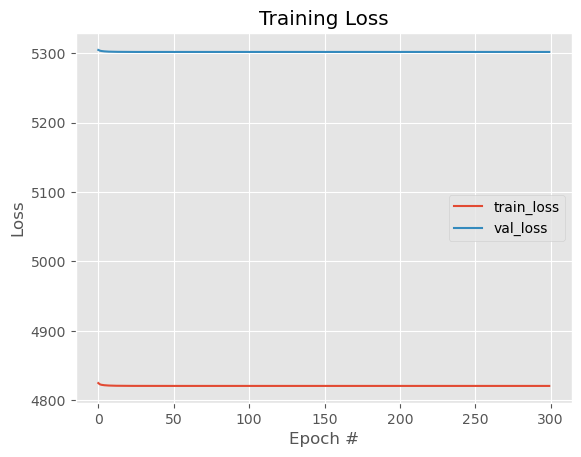

          start_census  hour               h3
0         1.703108e+10     0  852664c3fffffff
1         1.703184e+10     0  852664c3fffffff
2         1.703128e+10     0  852664c3fffffff
3         1.703108e+10     0  852664c3fffffff
4         1.703184e+10     0  852664c3fffffff
...                ...   ...              ...
16500977  1.703108e+10    23  852664c3fffffff
16500978  1.703108e+10    23  852664c3fffffff
16500979  1.703108e+10    23  852664c3fffffff
16500980  1.703124e+10    23  852664cbfffffff
16500981  1.703108e+10    23  852664c3fffffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  852664c3fffffff   1.0        37757
1         1.703184e+10         0  852664c3fffffff   1.0        40769
2         1.703128e+10         0  852664c3fffffff   1.0         7456
3         1.703108e+10         0  852664c3fffffff   1.0        20129
7         1.703108e+10         0  852664c3fffffff   1.0         8747
...  

36/36 [==============================] - 0s 3ms/step - loss: 1924.5547 - val_loss: 1514.9398
Epoch 138/300
36/36 [==============================] - 0s 2ms/step - loss: 1925.0955 - val_loss: 1497.3455
Epoch 139/300
36/36 [==============================] - 0s 2ms/step - loss: 1937.9362 - val_loss: 1518.1395
Epoch 140/300
36/36 [==============================] - 0s 3ms/step - loss: 1937.6523 - val_loss: 1510.0828
Epoch 141/300
36/36 [==============================] - 0s 3ms/step - loss: 1908.8973 - val_loss: 1506.8003
Epoch 142/300
36/36 [==============================] - 0s 2ms/step - loss: 1937.9001 - val_loss: 1552.3234
Epoch 143/300
36/36 [==============================] - 0s 2ms/step - loss: 1930.9967 - val_loss: 1485.9987
Epoch 144/300
36/36 [==============================] - 0s 2ms/step - loss: 1909.6815 - val_loss: 1460.1586
Epoch 145/300
36/36 [==============================] - 0s 3ms/step - loss: 1931.9667 - val_loss: 1614.0894
Epoch 146/300
36/36 [==============================

36/36 [==============================] - 0s 3ms/step - loss: 1860.3979 - val_loss: 1404.4047
Epoch 290/300
36/36 [==============================] - 0s 3ms/step - loss: 1863.1810 - val_loss: 1479.7324
Epoch 291/300
36/36 [==============================] - 0s 2ms/step - loss: 1818.3307 - val_loss: 1372.2987
Epoch 292/300
36/36 [==============================] - 0s 3ms/step - loss: 1825.5300 - val_loss: 1389.0188
Epoch 293/300
36/36 [==============================] - 0s 3ms/step - loss: 1804.2233 - val_loss: 1379.3531
Epoch 294/300
36/36 [==============================] - 0s 3ms/step - loss: 1808.4967 - val_loss: 1394.7007
Epoch 295/300
36/36 [==============================] - 0s 2ms/step - loss: 1804.2606 - val_loss: 1400.0405
Epoch 296/300
36/36 [==============================] - 0s 3ms/step - loss: 1797.4902 - val_loss: 1401.5375
Epoch 297/300
36/36 [==============================] - 0s 2ms/step - loss: 1789.8242 - val_loss: 1419.9315
Epoch 298/300
36/36 [==============================

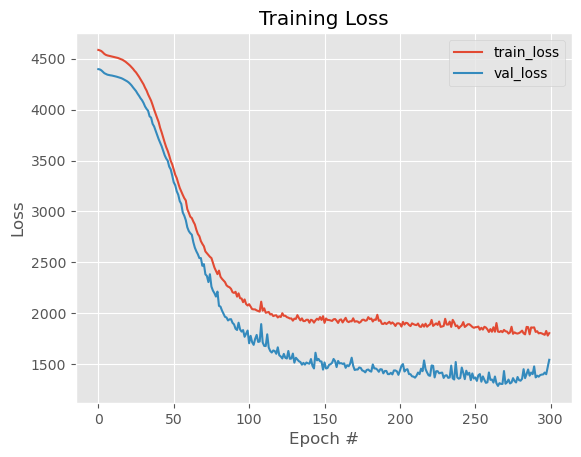

          start_census  hour               h3
0         1.703108e+10     0  872664c1effffff
1         1.703184e+10     0  872664c1affffff
2         1.703128e+10     0  872664c1affffff
3         1.703108e+10     0  872664c1effffff
4         1.703184e+10     0  872664c1affffff
...                ...   ...              ...
16500977  1.703108e+10    23  872664c1effffff
16500978  1.703108e+10    23  872664c1effffff
16500979  1.703108e+10    23  872664c1effffff
16500980  1.703124e+10    23  872664cacffffff
16500981  1.703108e+10    23  872664c1effffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  872664c1effffff   1.0        37757
1         1.703184e+10         0  872664c1affffff   1.0        40769
2         1.703128e+10         0  872664c1affffff   1.0         7456
3         1.703108e+10         0  872664c1effffff   1.0        20129
7         1.703108e+10         0  872664c1effffff   1.0         8747
...  

36/36 [==============================] - 0s 2ms/step - loss: 4193.8408 - val_loss: 3879.6541
Epoch 138/300
36/36 [==============================] - 0s 3ms/step - loss: 4193.8696 - val_loss: 3879.4351
Epoch 139/300
36/36 [==============================] - 0s 3ms/step - loss: 4193.5947 - val_loss: 3879.3342
Epoch 140/300
36/36 [==============================] - 0s 3ms/step - loss: 4193.5425 - val_loss: 3878.9680
Epoch 141/300
36/36 [==============================] - 0s 3ms/step - loss: 4193.2480 - val_loss: 3878.9495
Epoch 142/300
36/36 [==============================] - 0s 2ms/step - loss: 4192.9468 - val_loss: 3878.6282
Epoch 143/300
36/36 [==============================] - 0s 2ms/step - loss: 4192.6426 - val_loss: 3878.8777
Epoch 144/300
36/36 [==============================] - 0s 2ms/step - loss: 4192.5454 - val_loss: 3878.5930
Epoch 145/300
36/36 [==============================] - 0s 3ms/step - loss: 4192.5088 - val_loss: 3878.4504
Epoch 146/300
36/36 [==============================

36/36 [==============================] - 0s 3ms/step - loss: 4173.1294 - val_loss: 3862.4399
Epoch 290/300
36/36 [==============================] - 0s 3ms/step - loss: 4172.8638 - val_loss: 3862.6348
Epoch 291/300
36/36 [==============================] - 0s 2ms/step - loss: 4172.9062 - val_loss: 3862.6741
Epoch 292/300
36/36 [==============================] - 0s 2ms/step - loss: 4172.8530 - val_loss: 3862.4365
Epoch 293/300
36/36 [==============================] - 0s 3ms/step - loss: 4172.4321 - val_loss: 3862.2510
Epoch 294/300
36/36 [==============================] - 0s 2ms/step - loss: 4172.3389 - val_loss: 3862.0271
Epoch 295/300
36/36 [==============================] - 0s 2ms/step - loss: 4172.1060 - val_loss: 3861.8645
Epoch 296/300
36/36 [==============================] - 0s 3ms/step - loss: 4172.1973 - val_loss: 3861.9565
Epoch 297/300
36/36 [==============================] - 0s 2ms/step - loss: 4172.2383 - val_loss: 3862.6174
Epoch 298/300
36/36 [==============================

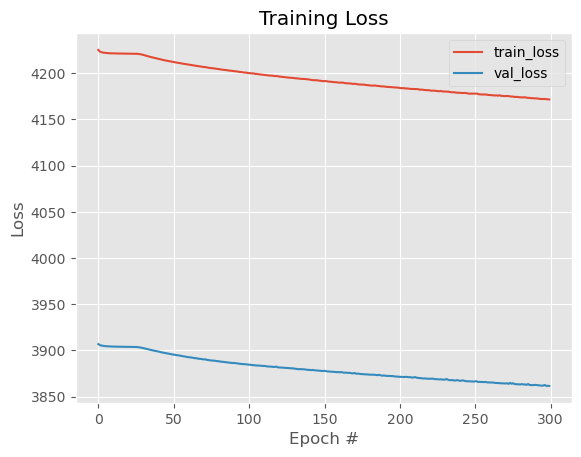

          start_census  hour               h3
0         1.703108e+10     0  892664c1e4fffff
1         1.703184e+10     0  892664c1a8bffff
2         1.703128e+10     0  892664c1acfffff
3         1.703108e+10     0  892664c1ec7ffff
4         1.703184e+10     0  892664c1a8bffff
...                ...   ...              ...
16500977  1.703108e+10    23  892664c1e73ffff
16500978  1.703108e+10    23  892664c1e0fffff
16500979  1.703108e+10    23  892664c1ea7ffff
16500980  1.703124e+10    23  892664cac03ffff
16500981  1.703108e+10    23  892664c1e0fffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  892664c1e4fffff   1.0        37757
1         1.703184e+10         0  892664c1a8bffff   1.0        40769
2         1.703128e+10         0  892664c1acfffff   1.0         7456
3         1.703108e+10         0  892664c1ec7ffff   1.0        20129
7         1.703108e+10         0  892664c1ed7ffff   1.0         8747
...  

36/36 [==============================] - 0s 2ms/step - loss: 1739.9475 - val_loss: 1416.3553
Epoch 138/300
36/36 [==============================] - 0s 2ms/step - loss: 1731.1670 - val_loss: 1462.1312
Epoch 139/300
36/36 [==============================] - 0s 3ms/step - loss: 1723.6962 - val_loss: 1419.9169
Epoch 140/300
36/36 [==============================] - 0s 3ms/step - loss: 1743.8599 - val_loss: 1429.2020
Epoch 141/300
36/36 [==============================] - 0s 2ms/step - loss: 1751.2831 - val_loss: 1504.0206
Epoch 142/300
36/36 [==============================] - 0s 2ms/step - loss: 1725.3309 - val_loss: 1475.3625
Epoch 143/300
36/36 [==============================] - 0s 2ms/step - loss: 1731.8466 - val_loss: 1451.4296
Epoch 144/300
36/36 [==============================] - 0s 2ms/step - loss: 1745.3776 - val_loss: 1450.3164
Epoch 145/300
36/36 [==============================] - 0s 2ms/step - loss: 1717.7826 - val_loss: 1413.7432
Epoch 146/300
36/36 [==============================

36/36 [==============================] - 0s 2ms/step - loss: 1696.0314 - val_loss: 1456.8126
Epoch 290/300
36/36 [==============================] - 0s 2ms/step - loss: 1683.4828 - val_loss: 1476.8428
Epoch 291/300
36/36 [==============================] - 0s 2ms/step - loss: 1686.5303 - val_loss: 1482.4548
Epoch 292/300
36/36 [==============================] - 0s 2ms/step - loss: 1674.3992 - val_loss: 1462.8851
Epoch 293/300
36/36 [==============================] - 0s 2ms/step - loss: 1679.8408 - val_loss: 1476.5736
Epoch 294/300
36/36 [==============================] - 0s 2ms/step - loss: 1678.1140 - val_loss: 1448.8746
Epoch 295/300
36/36 [==============================] - 0s 2ms/step - loss: 1690.6851 - val_loss: 1461.2157
Epoch 296/300
36/36 [==============================] - 0s 2ms/step - loss: 1710.8170 - val_loss: 1487.5302
Epoch 297/300
36/36 [==============================] - 0s 2ms/step - loss: 1689.5477 - val_loss: 1517.3892
Epoch 298/300
36/36 [==============================

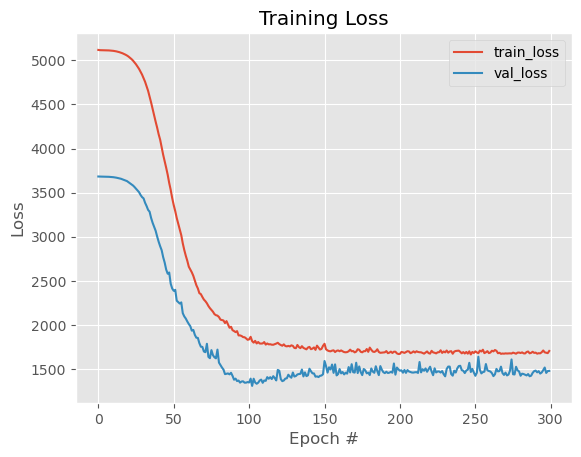

          start_census  hour               h3
0         1.703108e+10     0  832664fffffffff
1         1.703184e+10     0  832664fffffffff
2         1.703128e+10     0  832664fffffffff
3         1.703108e+10     0  832664fffffffff
4         1.703184e+10     0  832664fffffffff
...                ...   ...              ...
16500977  1.703108e+10    23  832664fffffffff
16500978  1.703108e+10    23  832664fffffffff
16500979  1.703108e+10    23  832664fffffffff
16500980  1.703124e+10    23  832664fffffffff
16500981  1.703108e+10    23  832664fffffffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  832664fffffffff   1.0        80078
1         1.703184e+10         0  832664fffffffff   1.0        58553
2         1.703128e+10         0  832664fffffffff   1.0        11315
3         1.703108e+10         0  832664fffffffff   1.0        48419
7         1.703108e+10         0  832664fffffffff   1.0        13610
...  

16/16 [==============================] - 0s 3ms/step - loss: 9767.4346 - val_loss: 11153.1504
Epoch 136/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4346 - val_loss: 11153.1484
Epoch 137/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4346 - val_loss: 11153.1494
Epoch 138/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4336 - val_loss: 11153.1484
Epoch 139/300
16/16 [==============================] - 0s 4ms/step - loss: 9767.4336 - val_loss: 11153.1475
Epoch 140/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4336 - val_loss: 11153.1484
Epoch 141/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4326 - val_loss: 11153.1465
Epoch 142/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4326 - val_loss: 11153.1465
Epoch 143/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4326 - val_loss: 11153.1445
Epoch 144/300
16/16 [=====================

Epoch 211/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4277 - val_loss: 11153.1367
Epoch 212/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4277 - val_loss: 11153.1367
Epoch 213/300
16/16 [==============================] - 0s 4ms/step - loss: 9767.4287 - val_loss: 11153.1357
Epoch 214/300
16/16 [==============================] - 0s 4ms/step - loss: 9767.4277 - val_loss: 11153.1367
Epoch 215/300
16/16 [==============================] - 0s 4ms/step - loss: 9767.4277 - val_loss: 11153.1367
Epoch 216/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4277 - val_loss: 11153.1357
Epoch 217/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4277 - val_loss: 11153.1357
Epoch 218/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4277 - val_loss: 11153.1367
Epoch 219/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4277 - val_loss: 11153.1367
Epoch 220/300
16/16 [=======

Epoch 287/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4277 - val_loss: 11153.1377
Epoch 288/300
16/16 [==============================] - 0s 4ms/step - loss: 9767.4277 - val_loss: 11153.1367
Epoch 289/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4277 - val_loss: 11153.1367
Epoch 290/300
16/16 [==============================] - 0s 4ms/step - loss: 9767.4277 - val_loss: 11153.1367
Epoch 291/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4277 - val_loss: 11153.1367
Epoch 292/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4287 - val_loss: 11153.1367
Epoch 293/300
16/16 [==============================] - 0s 4ms/step - loss: 9767.4277 - val_loss: 11153.1357
Epoch 294/300
16/16 [==============================] - 0s 4ms/step - loss: 9767.4287 - val_loss: 11153.1367
Epoch 295/300
16/16 [==============================] - 0s 3ms/step - loss: 9767.4297 - val_loss: 11153.1367
Epoch 296/300
16/16 [=======

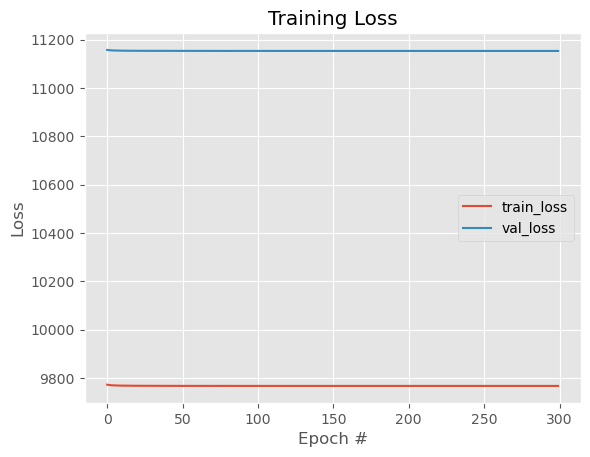

          start_census  hour               h3
0         1.703108e+10     0  852664c3fffffff
1         1.703184e+10     0  852664c3fffffff
2         1.703128e+10     0  852664c3fffffff
3         1.703108e+10     0  852664c3fffffff
4         1.703184e+10     0  852664c3fffffff
...                ...   ...              ...
16500977  1.703108e+10    23  852664c3fffffff
16500978  1.703108e+10    23  852664c3fffffff
16500979  1.703108e+10    23  852664c3fffffff
16500980  1.703124e+10    23  852664cbfffffff
16500981  1.703108e+10    23  852664c3fffffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  852664c3fffffff   1.0        80078
1         1.703184e+10         0  852664c3fffffff   1.0        58553
2         1.703128e+10         0  852664c3fffffff   1.0        11315
3         1.703108e+10         0  852664c3fffffff   1.0        48419
7         1.703108e+10         0  852664c3fffffff   1.0        13610
...  

16/16 [==============================] - 0s 3ms/step - loss: 10055.5352 - val_loss: 8818.7617
Epoch 136/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5332 - val_loss: 8818.7627
Epoch 137/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5332 - val_loss: 8818.7637
Epoch 138/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5332 - val_loss: 8818.7637
Epoch 139/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5332 - val_loss: 8818.7646
Epoch 140/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5332 - val_loss: 8818.7646
Epoch 141/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5322 - val_loss: 8818.7637
Epoch 142/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5352 - val_loss: 8818.7637
Epoch 143/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5332 - val_loss: 8818.7656
Epoch 144/300
16/16 [=====================

Epoch 211/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5293 - val_loss: 8818.8027
Epoch 212/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5312 - val_loss: 8818.8047
Epoch 213/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5312 - val_loss: 8818.8057
Epoch 214/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5293 - val_loss: 8818.8057
Epoch 215/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5293 - val_loss: 8818.8057
Epoch 216/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5303 - val_loss: 8818.8066
Epoch 217/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5293 - val_loss: 8818.8066
Epoch 218/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5293 - val_loss: 8818.8066
Epoch 219/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5303 - val_loss: 8818.8076
Epoch 220/300
16/16 [=======

Epoch 287/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5293 - val_loss: 8818.8076
Epoch 288/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5293 - val_loss: 8818.8086
Epoch 289/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5293 - val_loss: 8818.8086
Epoch 290/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5293 - val_loss: 8818.8057
Epoch 291/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5303 - val_loss: 8818.8086
Epoch 292/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5293 - val_loss: 8818.8076
Epoch 293/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5293 - val_loss: 8818.8076
Epoch 294/300
16/16 [==============================] - 0s 3ms/step - loss: 10055.5303 - val_loss: 8818.8066
Epoch 295/300
16/16 [==============================] - 0s 4ms/step - loss: 10055.5293 - val_loss: 8818.8086
Epoch 296/300
16/16 [=======

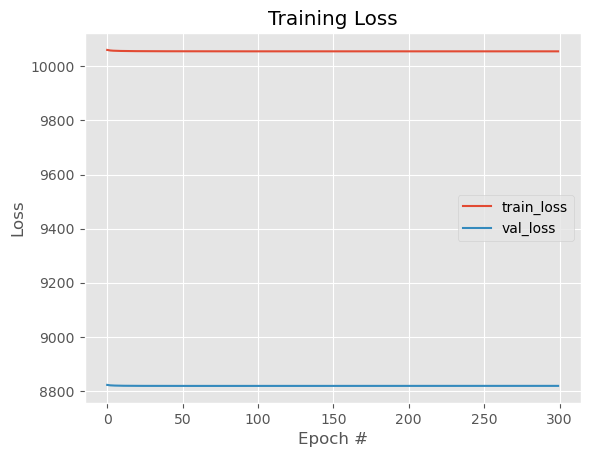

          start_census  hour               h3
0         1.703108e+10     0  872664c1effffff
1         1.703184e+10     0  872664c1affffff
2         1.703128e+10     0  872664c1affffff
3         1.703108e+10     0  872664c1effffff
4         1.703184e+10     0  872664c1affffff
...                ...   ...              ...
16500977  1.703108e+10    23  872664c1effffff
16500978  1.703108e+10    23  872664c1effffff
16500979  1.703108e+10    23  872664c1effffff
16500980  1.703124e+10    23  872664cacffffff
16500981  1.703108e+10    23  872664c1effffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  872664c1effffff   1.0        80078
1         1.703184e+10         0  872664c1affffff   1.0        58553
2         1.703128e+10         0  872664c1affffff   1.0        11315
3         1.703108e+10         0  872664c1effffff   1.0        48419
7         1.703108e+10         0  872664c1effffff   1.0        13610
...  

16/16 [==============================] - 0s 4ms/step - loss: 9356.6748 - val_loss: 10787.9951
Epoch 136/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6738 - val_loss: 10787.9951
Epoch 137/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6748 - val_loss: 10787.9961
Epoch 138/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6719 - val_loss: 10787.9951
Epoch 139/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6738 - val_loss: 10787.9951
Epoch 140/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6748 - val_loss: 10787.9951
Epoch 141/300
16/16 [==============================] - 0s 4ms/step - loss: 9356.6738 - val_loss: 10787.9951
Epoch 142/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6738 - val_loss: 10787.9951
Epoch 143/300
16/16 [==============================] - 0s 4ms/step - loss: 9356.6719 - val_loss: 10787.9951
Epoch 144/300
16/16 [=====================

Epoch 211/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6738 - val_loss: 10787.9922
Epoch 212/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6738 - val_loss: 10787.9922
Epoch 213/300
16/16 [==============================] - 0s 4ms/step - loss: 9356.6748 - val_loss: 10787.9912
Epoch 214/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6719 - val_loss: 10787.9922
Epoch 215/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6738 - val_loss: 10787.9932
Epoch 216/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6738 - val_loss: 10787.9922
Epoch 217/300
16/16 [==============================] - 0s 4ms/step - loss: 9356.6738 - val_loss: 10787.9922
Epoch 218/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6748 - val_loss: 10787.9912
Epoch 219/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6758 - val_loss: 10787.9922
Epoch 220/300
16/16 [=======

Epoch 287/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6738 - val_loss: 10787.9873
Epoch 288/300
16/16 [==============================] - 0s 4ms/step - loss: 9356.6719 - val_loss: 10787.9863
Epoch 289/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6738 - val_loss: 10787.9873
Epoch 290/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6719 - val_loss: 10787.9873
Epoch 291/300
16/16 [==============================] - 0s 4ms/step - loss: 9356.6719 - val_loss: 10787.9863
Epoch 292/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6738 - val_loss: 10787.9873
Epoch 293/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6719 - val_loss: 10787.9873
Epoch 294/300
16/16 [==============================] - 0s 3ms/step - loss: 9356.6719 - val_loss: 10787.9863
Epoch 295/300
16/16 [==============================] - 0s 4ms/step - loss: 9356.6738 - val_loss: 10787.9873
Epoch 296/300
16/16 [=======

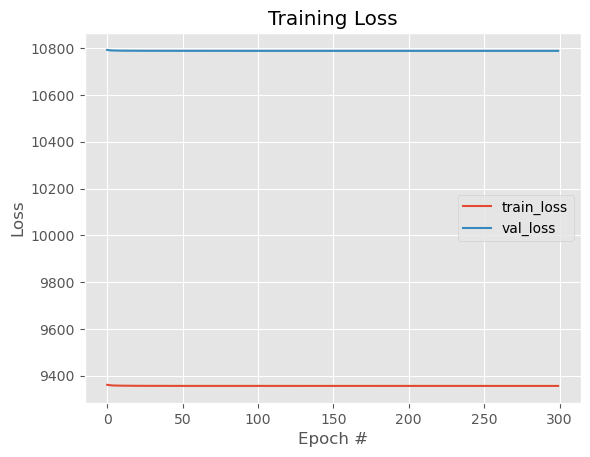

          start_census  hour               h3
0         1.703108e+10     0  892664c1e4fffff
1         1.703184e+10     0  892664c1a8bffff
2         1.703128e+10     0  892664c1acfffff
3         1.703108e+10     0  892664c1ec7ffff
4         1.703184e+10     0  892664c1a8bffff
...                ...   ...              ...
16500977  1.703108e+10    23  892664c1e73ffff
16500978  1.703108e+10    23  892664c1e0fffff
16500979  1.703108e+10    23  892664c1ea7ffff
16500980  1.703124e+10    23  892664cac03ffff
16500981  1.703108e+10    23  892664c1e0fffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  892664c1e4fffff   1.0        80078
1         1.703184e+10         0  892664c1a8bffff   1.0        58553
2         1.703128e+10         0  892664c1acfffff   1.0        11315
3         1.703108e+10         0  892664c1ec7ffff   1.0        48419
7         1.703108e+10         0  892664c1ed7ffff   1.0        13610
...  

16/16 [==============================] - 0s 4ms/step - loss: 12257.4912 - val_loss: 7686.2891
Epoch 136/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4902 - val_loss: 7686.2939
Epoch 137/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4893 - val_loss: 7686.2988
Epoch 138/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4902 - val_loss: 7686.3018
Epoch 139/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4902 - val_loss: 7686.3042
Epoch 140/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4902 - val_loss: 7686.3057
Epoch 141/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4893 - val_loss: 7686.3081
Epoch 142/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4873 - val_loss: 7686.3096
Epoch 143/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4893 - val_loss: 7686.3154
Epoch 144/300
16/16 [=====================

Epoch 211/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4795 - val_loss: 7686.4448
Epoch 212/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4785 - val_loss: 7686.4419
Epoch 213/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4805 - val_loss: 7686.4434
Epoch 214/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4805 - val_loss: 7686.4468
Epoch 215/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4785 - val_loss: 7686.4429
Epoch 216/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4795 - val_loss: 7686.4438
Epoch 217/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4785 - val_loss: 7686.4497
Epoch 218/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4795 - val_loss: 7686.4507
Epoch 219/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4795 - val_loss: 7686.4536
Epoch 220/300
16/16 [=======

Epoch 287/300
16/16 [==============================] - 0s 4ms/step - loss: 12257.4756 - val_loss: 7686.5391
Epoch 288/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4756 - val_loss: 7686.5376
Epoch 289/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4766 - val_loss: 7686.5410
Epoch 290/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4746 - val_loss: 7686.5410
Epoch 291/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4766 - val_loss: 7686.5391
Epoch 292/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4775 - val_loss: 7686.5420
Epoch 293/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4766 - val_loss: 7686.5435
Epoch 294/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4756 - val_loss: 7686.5430
Epoch 295/300
16/16 [==============================] - 0s 3ms/step - loss: 12257.4756 - val_loss: 7686.5449
Epoch 296/300
16/16 [=======

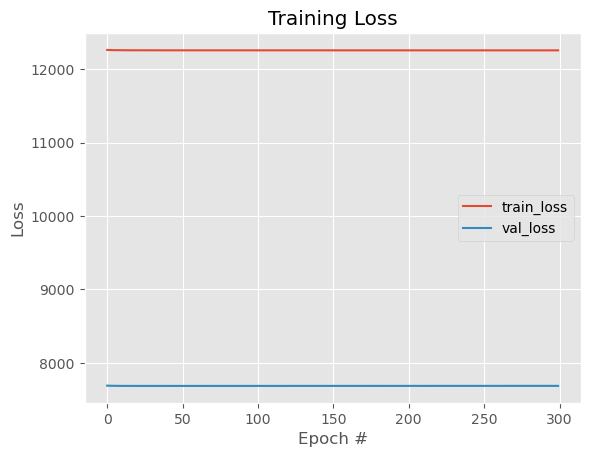

          start_census  hour               h3
0         1.703108e+10     0  832664fffffffff
1         1.703184e+10     0  832664fffffffff
2         1.703128e+10     0  832664fffffffff
3         1.703108e+10     0  832664fffffffff
4         1.703184e+10     0  832664fffffffff
...                ...   ...              ...
16500977  1.703108e+10    23  832664fffffffff
16500978  1.703108e+10    23  832664fffffffff
16500979  1.703108e+10    23  832664fffffffff
16500980  1.703124e+10    23  832664fffffffff
16500981  1.703108e+10    23  832664fffffffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  832664fffffffff   1.0       554152
1         1.703184e+10         0  832664fffffffff   1.0      2914312
2         1.703128e+10         0  832664fffffffff   1.0       912823
3         1.703108e+10         0  832664fffffffff   1.0       165758
7         1.703108e+10         0  832664fffffffff   1.0       163679
...  

6/6 [==============================] - 0s 8ms/step - loss: 40499.3906 - val_loss: 20313.9961
Epoch 137/300
6/6 [==============================] - 0s 8ms/step - loss: 40499.3945 - val_loss: 20313.9883
Epoch 138/300
6/6 [==============================] - 0s 7ms/step - loss: 40499.3945 - val_loss: 20313.9824
Epoch 139/300
6/6 [==============================] - 0s 7ms/step - loss: 40499.3945 - val_loss: 20313.9785
Epoch 140/300
6/6 [==============================] - 0s 8ms/step - loss: 40499.3945 - val_loss: 20313.9746
Epoch 141/300
6/6 [==============================] - 0s 8ms/step - loss: 40499.3906 - val_loss: 20313.9727
Epoch 142/300
6/6 [==============================] - 0s 8ms/step - loss: 40499.3906 - val_loss: 20313.9668
Epoch 143/300
6/6 [==============================] - 0s 8ms/step - loss: 40499.3867 - val_loss: 20313.9648
Epoch 144/300
6/6 [==============================] - 0s 8ms/step - loss: 40499.3906 - val_loss: 20313.9629
Epoch 145/300
6/6 [==============================] 

6/6 [==============================] - 0s 8ms/step - loss: 40499.2891 - val_loss: 20313.5000
Epoch 289/300
6/6 [==============================] - 0s 8ms/step - loss: 40499.2891 - val_loss: 20313.5000
Epoch 290/300
6/6 [==============================] - 0s 7ms/step - loss: 40499.2891 - val_loss: 20313.5000
Epoch 291/300
6/6 [==============================] - 0s 7ms/step - loss: 40499.2891 - val_loss: 20313.5000
Epoch 292/300
6/6 [==============================] - 0s 7ms/step - loss: 40499.2891 - val_loss: 20313.5000
Epoch 293/300
6/6 [==============================] - 0s 7ms/step - loss: 40499.2891 - val_loss: 20313.5000
Epoch 294/300
6/6 [==============================] - 0s 8ms/step - loss: 40499.2891 - val_loss: 20313.5000
Epoch 295/300
6/6 [==============================] - 0s 8ms/step - loss: 40499.2891 - val_loss: 20313.5020
Epoch 296/300
6/6 [==============================] - 0s 8ms/step - loss: 40499.2891 - val_loss: 20313.5020
Epoch 297/300
6/6 [==============================] 

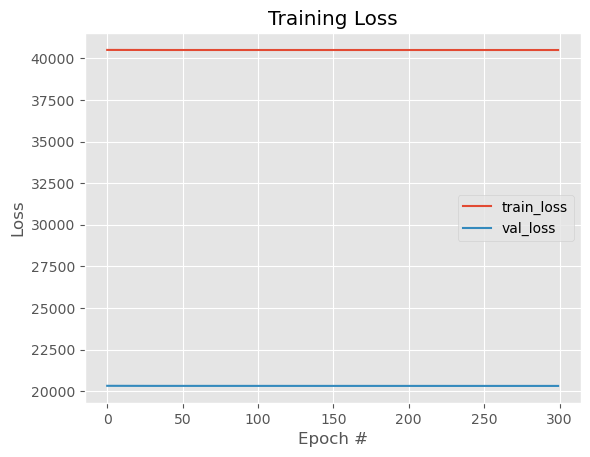

          start_census  hour               h3
0         1.703108e+10     0  852664c3fffffff
1         1.703184e+10     0  852664c3fffffff
2         1.703128e+10     0  852664c3fffffff
3         1.703108e+10     0  852664c3fffffff
4         1.703184e+10     0  852664c3fffffff
...                ...   ...              ...
16500977  1.703108e+10    23  852664c3fffffff
16500978  1.703108e+10    23  852664c3fffffff
16500979  1.703108e+10    23  852664c3fffffff
16500980  1.703124e+10    23  852664cbfffffff
16500981  1.703108e+10    23  852664c3fffffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  852664c3fffffff   1.0       554152
1         1.703184e+10         0  852664c3fffffff   1.0      2914312
2         1.703128e+10         0  852664c3fffffff   1.0       912823
3         1.703108e+10         0  852664c3fffffff   1.0       165758
7         1.703108e+10         0  852664c3fffffff   1.0       163679
...  

6/6 [==============================] - 0s 8ms/step - loss: 22311.0176 - val_loss: 30564.5957
Epoch 137/300
6/6 [==============================] - 0s 7ms/step - loss: 22287.6680 - val_loss: 30450.6289
Epoch 138/300
6/6 [==============================] - 0s 7ms/step - loss: 22272.5273 - val_loss: 30486.0273
Epoch 139/300
6/6 [==============================] - 0s 8ms/step - loss: 22256.1074 - val_loss: 30576.3320
Epoch 140/300
6/6 [==============================] - 0s 8ms/step - loss: 22253.2188 - val_loss: 30574.1680
Epoch 141/300
6/6 [==============================] - 0s 8ms/step - loss: 22251.8789 - val_loss: 30543.3965
Epoch 142/300
6/6 [==============================] - 0s 8ms/step - loss: 22284.1895 - val_loss: 30419.0723
Epoch 143/300
6/6 [==============================] - 0s 7ms/step - loss: 22242.5684 - val_loss: 30470.7969
Epoch 144/300
6/6 [==============================] - 0s 8ms/step - loss: 22219.7734 - val_loss: 30471.7871
Epoch 145/300
6/6 [==============================] 

6/6 [==============================] - 0s 8ms/step - loss: 18642.1094 - val_loss: 31396.9434
Epoch 289/300
6/6 [==============================] - 0s 8ms/step - loss: 18550.5547 - val_loss: 31470.0273
Epoch 290/300
6/6 [==============================] - 0s 8ms/step - loss: 18501.7227 - val_loss: 31439.6914
Epoch 291/300
6/6 [==============================] - 0s 7ms/step - loss: 18455.5781 - val_loss: 31450.4609
Epoch 292/300
6/6 [==============================] - 0s 8ms/step - loss: 18416.1699 - val_loss: 31396.8027
Epoch 293/300
6/6 [==============================] - 0s 7ms/step - loss: 18399.1094 - val_loss: 31461.3770
Epoch 294/300
6/6 [==============================] - 0s 8ms/step - loss: 18364.7734 - val_loss: 31443.7246
Epoch 295/300
6/6 [==============================] - 0s 8ms/step - loss: 18334.5195 - val_loss: 31523.6172
Epoch 296/300
6/6 [==============================] - 0s 8ms/step - loss: 18225.3691 - val_loss: 31539.6016
Epoch 297/300
6/6 [==============================] 

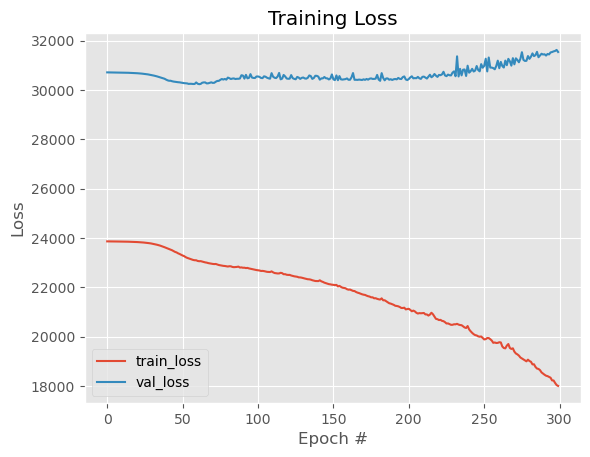

          start_census  hour               h3
0         1.703108e+10     0  872664c1effffff
1         1.703184e+10     0  872664c1affffff
2         1.703128e+10     0  872664c1affffff
3         1.703108e+10     0  872664c1effffff
4         1.703184e+10     0  872664c1affffff
...                ...   ...              ...
16500977  1.703108e+10    23  872664c1effffff
16500978  1.703108e+10    23  872664c1effffff
16500979  1.703108e+10    23  872664c1effffff
16500980  1.703124e+10    23  872664cacffffff
16500981  1.703108e+10    23  872664c1effffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  872664c1effffff   1.0       554152
1         1.703184e+10         0  872664c1affffff   1.0      2914312
2         1.703128e+10         0  872664c1affffff   1.0       912823
3         1.703108e+10         0  872664c1effffff   1.0       165758
7         1.703108e+10         0  872664c1effffff   1.0       163679
...  

6/6 [==============================] - 0s 8ms/step - loss: 32784.3750 - val_loss: 24217.8926
Epoch 137/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.3672 - val_loss: 24217.8965
Epoch 138/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.3633 - val_loss: 24217.8965
Epoch 139/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.3633 - val_loss: 24217.8984
Epoch 140/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.3594 - val_loss: 24217.8984
Epoch 141/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.3516 - val_loss: 24217.8984
Epoch 142/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.3516 - val_loss: 24217.8984
Epoch 143/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.3438 - val_loss: 24217.8984
Epoch 144/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.3438 - val_loss: 24217.8984
Epoch 145/300
6/6 [==============================] 

6/6 [==============================] - 0s 7ms/step - loss: 32784.1250 - val_loss: 24218.1289
Epoch 289/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.1172 - val_loss: 24218.1328
Epoch 290/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.1250 - val_loss: 24218.1348
Epoch 291/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.1211 - val_loss: 24218.1406
Epoch 292/300
6/6 [==============================] - 0s 7ms/step - loss: 32784.1172 - val_loss: 24218.1406
Epoch 293/300
6/6 [==============================] - 0s 8ms/step - loss: 32784.1172 - val_loss: 24218.1406
Epoch 294/300
6/6 [==============================] - 0s 11ms/step - loss: 32784.1211 - val_loss: 24218.1406
Epoch 295/300
6/6 [==============================] - 0s 10ms/step - loss: 32784.1172 - val_loss: 24218.1465
Epoch 296/300
6/6 [==============================] - 0s 9ms/step - loss: 32784.1172 - val_loss: 24218.1484
Epoch 297/300
6/6 [==============================

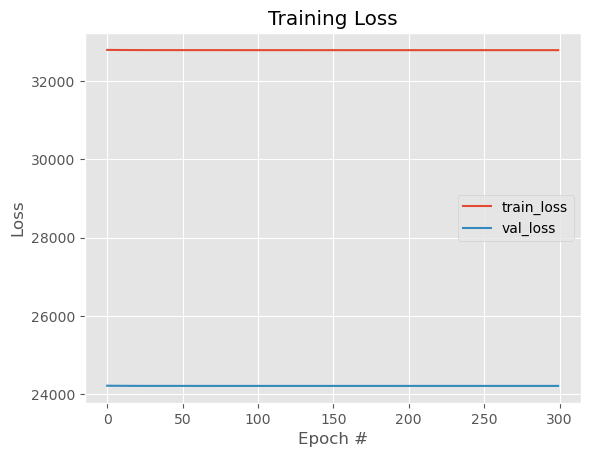

          start_census  hour               h3
0         1.703108e+10     0  892664c1e4fffff
1         1.703184e+10     0  892664c1a8bffff
2         1.703128e+10     0  892664c1acfffff
3         1.703108e+10     0  892664c1ec7ffff
4         1.703184e+10     0  892664c1a8bffff
...                ...   ...              ...
16500977  1.703108e+10    23  892664c1e73ffff
16500978  1.703108e+10    23  892664c1e0fffff
16500979  1.703108e+10    23  892664c1ea7ffff
16500980  1.703124e+10    23  892664cac03ffff
16500981  1.703108e+10    23  892664c1e0fffff

[16500982 rows x 3 columns]
          start_census  new_hour               h3  temp  occurrences
0         1.703108e+10         0  892664c1e4fffff   1.0       554152
1         1.703184e+10         0  892664c1a8bffff   1.0      2914312
2         1.703128e+10         0  892664c1acfffff   1.0       912823
3         1.703108e+10         0  892664c1ec7ffff   1.0       165758
7         1.703108e+10         0  892664c1ed7ffff   1.0       163679
...  

6/6 [==============================] - 0s 8ms/step - loss: 27949.5371 - val_loss: 15792.7793
Epoch 137/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.5312 - val_loss: 15792.7725
Epoch 138/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.5312 - val_loss: 15792.7656
Epoch 139/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.5273 - val_loss: 15792.7588
Epoch 140/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.5234 - val_loss: 15792.7539
Epoch 141/300
6/6 [==============================] - 0s 7ms/step - loss: 27949.5195 - val_loss: 15792.7471
Epoch 142/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.5234 - val_loss: 15792.7441
Epoch 143/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.5195 - val_loss: 15792.7383
Epoch 144/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.5137 - val_loss: 15792.7334
Epoch 145/300
6/6 [==============================] 

6/6 [==============================] - 0s 8ms/step - loss: 27949.4004 - val_loss: 15792.3584
Epoch 289/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.4043 - val_loss: 15792.3564
Epoch 290/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.4043 - val_loss: 15792.3564
Epoch 291/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.4062 - val_loss: 15792.3564
Epoch 292/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.4062 - val_loss: 15792.3535
Epoch 293/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.4043 - val_loss: 15792.3516
Epoch 294/300
6/6 [==============================] - 0s 8ms/step - loss: 27949.4043 - val_loss: 15792.3516
Epoch 295/300
6/6 [==============================] - 0s 10ms/step - loss: 27949.4062 - val_loss: 15792.3516
Epoch 296/300
6/6 [==============================] - 0s 9ms/step - loss: 27949.4062 - val_loss: 15792.3516
Epoch 297/300
6/6 [==============================]

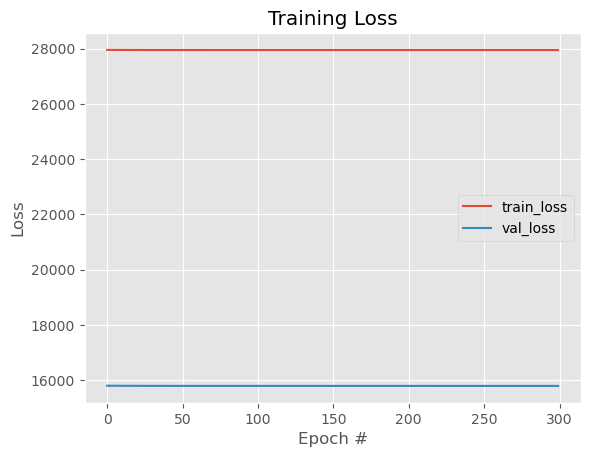


KeyboardInterrupt



In [10]:
lr = [0.01, 0.03, 0.1, 0.05]
resolution = [1, 2, 6, 24]
hex_res = [3, 5, 7, 9]
result_list = []
for i in lr:
    for j in resolution:
        for k in hex_res:
            data1 = create_dataset(work_data,resolution=j,h3_res = k)
            network1 = models.Sequential()
            print(data1.shape)

            network1.add(layers.Dense(1, activation='relu', input_shape=(data1.shape[1]-1,)))
            network1.add(layers.Dense(1, activation='linear'))
            
            print("lr: ", i, " Hour_res: ", j, " Hex_res: ", k)
            TN1 = Train_Net(data1, network1, batch_size = 64, epochs = 300, learning_rate=i)
            loss, H = TN1.train_net()
            result_list.append(("lr: "+ i+ " Hour_res: "+ j+ " Hex_res: "+k+ " Test_loss: "+ loss))

In [11]:
result_list

[('lr: ',
  0.01,
  ' Hour_res: ',
  1,
  ' Hex_res: ',
  3,
  ' Test_loss: ',
  1331.3250732421875),
 ('lr: ',
  0.01,
  ' Hour_res: ',
  1,
  ' Hex_res: ',
  5,
  ' Test_loss: ',
  2793.6904296875),
 ('lr: ',
  0.01,
  ' Hour_res: ',
  1,
  ' Hex_res: ',
  7,
  ' Test_loss: ',
  1311.3277587890625),
 ('lr: ',
  0.01,
  ' Hour_res: ',
  1,
  ' Hex_res: ',
  9,
  ' Test_loss: ',
  1228.3486328125),
 ('lr: ',
  0.01,
  ' Hour_res: ',
  2,
  ' Hex_res: ',
  3,
  ' Test_loss: ',
  3477.8896484375),
 ('lr: ',
  0.01,
  ' Hour_res: ',
  2,
  ' Hex_res: ',
  5,
  ' Test_loss: ',
  1640.0487060546875),
 ('lr: ',
  0.01,
  ' Hour_res: ',
  2,
  ' Hex_res: ',
  7,
  ' Test_loss: ',
  6467.76318359375),
 ('lr: ',
  0.01,
  ' Hour_res: ',
  2,
  ' Hex_res: ',
  9,
  ' Test_loss: ',
  1808.7408447265625),
 ('lr: ',
  0.01,
  ' Hour_res: ',
  6,
  ' Hex_res: ',
  3,
  ' Test_loss: ',
  12851.0673828125),
 ('lr: ',
  0.01,
  ' Hour_res: ',
  6,
  ' Hex_res: ',
  5,
  ' Test_loss: ',
  13798.29589843

In [ ]:
#test without onehot encoding, doesnt seem to change anything

                 start_census  hour        lat        lng
h3_03                                                    
832664fffffffff  1.703108e+10     0  41.893216 -87.637844
832664fffffffff  1.703184e+10     0  41.880994 -87.632746
832664fffffffff  1.703128e+10     0  41.879255 -87.642649
832664fffffffff  1.703108e+10     0  41.900221 -87.629105
832664fffffffff  1.703184e+10     0  41.880994 -87.632746
...                       ...   ...        ...        ...
832664fffffffff  1.703108e+10    23  41.892042 -87.631864
832664fffffffff  1.703108e+10    23  41.892508 -87.626215
832664fffffffff  1.703108e+10    23  41.891972 -87.612945
832664fffffffff  1.703124e+10    23  41.906026 -87.675312
832664fffffffff  1.703108e+10    23  41.892508 -87.626215

[16500982 rows x 4 columns]
          start_census  hour               h3
0         1.703108e+10     0  832664fffffffff
1         1.703184e+10     0  832664fffffffff
2         1.703128e+10     0  832664fffffffff
3         1.703108e+10     0  832

61/61 [==============================] - 0s 2ms/step - loss: 2833.7827 - val_loss: 2608.8296
Epoch 128/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7842 - val_loss: 2608.8291
Epoch 129/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7827 - val_loss: 2608.8308
Epoch 130/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7830 - val_loss: 2608.8293
Epoch 131/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7830 - val_loss: 2608.8298
Epoch 132/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7832 - val_loss: 2608.8301
Epoch 133/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7834 - val_loss: 2608.8298
Epoch 134/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7834 - val_loss: 2608.8301
Epoch 135/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7832 - val_loss: 2608.8293
Epoch 136/300
61/61 [==============================

61/61 [==============================] - 0s 2ms/step - loss: 2833.7832 - val_loss: 2608.8298
Epoch 280/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7832 - val_loss: 2608.8315
Epoch 281/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7830 - val_loss: 2608.8311
Epoch 282/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7830 - val_loss: 2608.8298
Epoch 283/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7830 - val_loss: 2608.8301
Epoch 284/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7834 - val_loss: 2608.8293
Epoch 285/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7832 - val_loss: 2608.8298
Epoch 286/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7830 - val_loss: 2608.8301
Epoch 287/300
61/61 [==============================] - 0s 2ms/step - loss: 2833.7834 - val_loss: 2608.8301
Epoch 288/300
61/61 [==============================

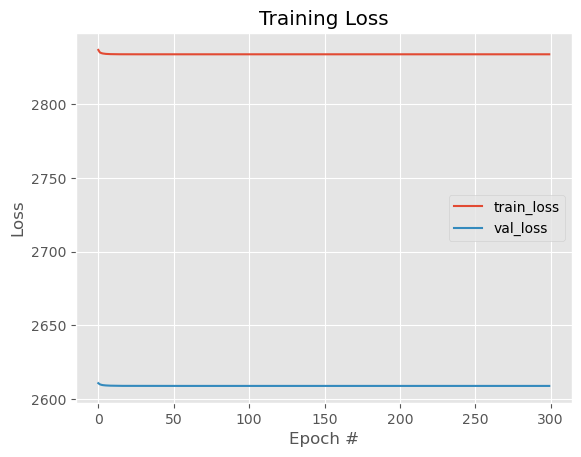

                 start_census  hour        lat        lng
h3_05                                                    
852664c3fffffff  1.703108e+10     0  41.893216 -87.637844
852664c3fffffff  1.703184e+10     0  41.880994 -87.632746
852664c3fffffff  1.703128e+10     0  41.879255 -87.642649
852664c3fffffff  1.703108e+10     0  41.900221 -87.629105
852664c3fffffff  1.703184e+10     0  41.880994 -87.632746
...                       ...   ...        ...        ...
852664c3fffffff  1.703108e+10    23  41.892042 -87.631864
852664c3fffffff  1.703108e+10    23  41.892508 -87.626215
852664c3fffffff  1.703108e+10    23  41.891972 -87.612945
852664cbfffffff  1.703124e+10    23  41.906026 -87.675312
852664c3fffffff  1.703108e+10    23  41.892508 -87.626215

[16500982 rows x 4 columns]
          start_census  hour               h3
0         1.703108e+10     0  852664c3fffffff
1         1.703184e+10     0  852664c3fffffff
2         1.703128e+10     0  852664c3fffffff
3         1.703108e+10     0  852

61/61 [==============================] - 0s 2ms/step - loss: 2461.4111 - val_loss: 3446.2268
Epoch 128/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4111 - val_loss: 3446.2268
Epoch 129/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4111 - val_loss: 3446.2268
Epoch 130/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4111 - val_loss: 3446.2268
Epoch 131/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4111 - val_loss: 3446.2268
Epoch 132/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4111 - val_loss: 3446.2266
Epoch 133/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4106 - val_loss: 3446.2266
Epoch 134/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4111 - val_loss: 3446.2271
Epoch 135/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4106 - val_loss: 3446.2266
Epoch 136/300
61/61 [==============================

61/61 [==============================] - 0s 2ms/step - loss: 2461.4114 - val_loss: 3446.2268
Epoch 280/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4111 - val_loss: 3446.2268
Epoch 281/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4109 - val_loss: 3446.2263
Epoch 282/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4114 - val_loss: 3446.2261
Epoch 283/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4114 - val_loss: 3446.2268
Epoch 284/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4109 - val_loss: 3446.2258
Epoch 285/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4109 - val_loss: 3446.2261
Epoch 286/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4111 - val_loss: 3446.2266
Epoch 287/300
61/61 [==============================] - 0s 2ms/step - loss: 2461.4114 - val_loss: 3446.2268
Epoch 288/300
61/61 [==============================

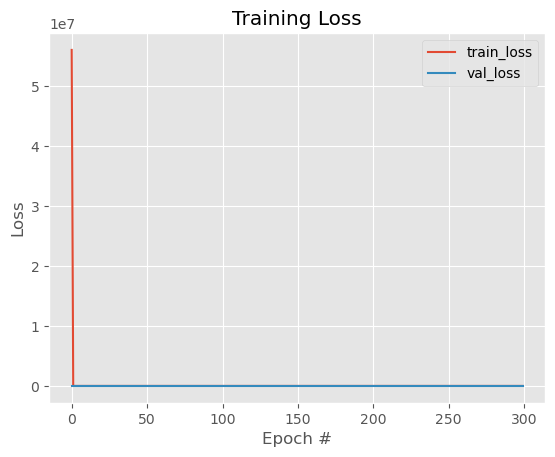

                 start_census  hour        lat        lng
h3_07                                                    
872664c1effffff  1.703108e+10     0  41.893216 -87.637844
872664c1affffff  1.703184e+10     0  41.880994 -87.632746
872664c1affffff  1.703128e+10     0  41.879255 -87.642649
872664c1effffff  1.703108e+10     0  41.900221 -87.629105
872664c1affffff  1.703184e+10     0  41.880994 -87.632746
...                       ...   ...        ...        ...
872664c1effffff  1.703108e+10    23  41.892042 -87.631864
872664c1effffff  1.703108e+10    23  41.892508 -87.626215
872664c1effffff  1.703108e+10    23  41.891972 -87.612945
872664cacffffff  1.703124e+10    23  41.906026 -87.675312
872664c1effffff  1.703108e+10    23  41.892508 -87.626215

[16500982 rows x 4 columns]
          start_census  hour               h3
0         1.703108e+10     0  872664c1effffff
1         1.703184e+10     0  872664c1affffff
2         1.703128e+10     0  872664c1affffff
3         1.703108e+10     0  872

61/61 [==============================] - 0s 2ms/step - loss: 2721.5125 - val_loss: 2408.2490
Epoch 128/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5112 - val_loss: 2408.2483
Epoch 129/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5120 - val_loss: 2408.2483
Epoch 130/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5117 - val_loss: 2408.2485
Epoch 131/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5112 - val_loss: 2408.2485
Epoch 132/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5120 - val_loss: 2408.2490
Epoch 133/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5120 - val_loss: 2408.2488
Epoch 134/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5127 - val_loss: 2408.2488
Epoch 135/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5110 - val_loss: 2408.2493
Epoch 136/300
61/61 [==============================

61/61 [==============================] - 0s 2ms/step - loss: 2721.5122 - val_loss: 2408.2485
Epoch 280/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5117 - val_loss: 2408.2490
Epoch 281/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5117 - val_loss: 2408.2485
Epoch 282/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5127 - val_loss: 2408.2485
Epoch 283/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5117 - val_loss: 2408.2483
Epoch 284/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5117 - val_loss: 2408.2485
Epoch 285/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5112 - val_loss: 2408.2485
Epoch 286/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5120 - val_loss: 2408.2483
Epoch 287/300
61/61 [==============================] - 0s 2ms/step - loss: 2721.5112 - val_loss: 2408.2483
Epoch 288/300
61/61 [==============================

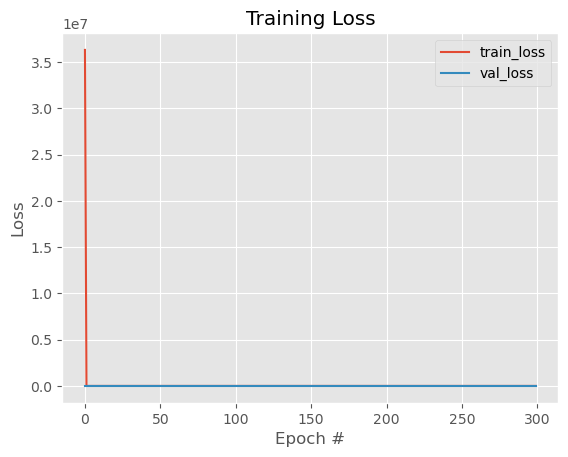

KeyboardInterrupt: 

In [66]:
lr = [0.01,0.03, 0.1, 0.05]
resolution = [1, 2, 6, 24]
hex_res = [3, 5, 7, 9]
result_list = []
for i in lr:
    for j in resolution:
        for k in hex_res:
            data1 = create_dataset3(work_data,resolution=j,h3_res = k)
            network1 = models.Sequential()
            print(data1.shape)

            network1.add(layers.Dense(1, activation='relu', input_shape=(data1.shape[1]-1,)))
            network1.add(layers.Dense(1, activation='linear'))
            
            print("lr: ", i, " Hour_res: ", j, " Hex_res: ", k)
            TN1 = Train_Net(np.asarray(data1).astype('float32'), network1, batch_size = 64, epochs = 300, learning_rate=i)
            loss, H = TN1.train_net()
            result_list.append(("lr: ", i, " Hour_res: ", j, " Hex_res: ",k, " Test_loss: ", loss))

In [ ]:
def create_dataset3(data, resolution=4, use_h3=True, h3_res = 3):
    df = data.copy()
    df = df.h3.geo_to_h3(h3_res)
    df["h3"] = df.index
    df = df.loc[:, ("start_census","hour","h3")].copy()
    df.reset_index(inplace=True,drop=True)
    df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
    df = df.drop('hour', axis=1)
    df['new_hour'] = df['new_hour'].astype(int)
    df["temp"] = np.ones(df.shape[0])
    df['occurrences'] = df.groupby(["start_census","new_hour","h3"]).transform('count')
    df = df.drop('temp', axis=1)
    df.drop_duplicates(inplace=True)
    df['h3'] = df['h3'].astype('category').cat.codes
    return df.to_numpy()
        

this is just for fun. nothin to do with the task anymore.

In [ ]:
data1 = create_dataset(df,resolution=1)
data2 = create_dataset_more_data(df,resolution=1)

In [ ]:
network2 = models.Sequential()

network2.add(layers.Dense(data2.shape[1]-1, activation='relu', input_shape=(data2.shape[1]-1,)))
network2.add(layers.Dense(data2.shape[1]-1, activation='relu', input_shape=(data2.shape[1]-1,)))
network2.add(layers.Dense(512, activation='relu', input_shape=(data2.shape[1]-1,)))

network2.add(layers.Dense(1, activation='linear'))


In [ ]:
network1 = models.Sequential()

network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(512, activation='relu', input_shape=(data1.shape[1]-1,)))

network1.add(layers.Dense(1, activation='linear'))


In [ ]:
network1 = models.Sequential()

network1.add(layers.Dense(560, activation='relu', input_shape=(560,)))
network1.add(layers.Dense(560, activation='relu', input_shape=(560,)))
network1.add(layers.Dense(512, activation='relu', input_shape=(560,)))

network1.add(layers.Dense(1, activation='linear'))


In [ ]:
TN2 = Train_Net(data2, network2, epochs = 15)

In [ ]:
loss, H = TN2.train_net()

In [ ]:
TN1 = Train_Net(data1, network1, batch_size = 64, epochs = 500)

In [ ]:
loss, H = TN1.train_net()

In [ ]:
print(pd.DataFrame(data1))